# INTRODUCCIÓN

Objetivo de Interconnect: Pronosticar su tasa de cancelación de clientes.

Para cumplir con lo requerido iniciaremos con un análisis exploratorio de datos teniendo en cuenta algunos aspectos importantes que señala Interconnect.

    1.- Comunicación por teléfono fijo. Se informa que ofrece la posibilidad de un servicio con conexión multilínea para el celular.
    2.- Internet. Ofrece la posibilidad de configurar la red a través de una DSL o Fibra Óptica.
Se han de señalar, pues serán aspectos importantes a tener en cuenta respecto al porqué el cliente podría cancelar el servicio de Interconnect, además de, naturalmente, conocer las estadísticas de abandono en nuestro análisis exploratorio de datos inicial respecto a tales características.

A parte de lo anterior nos terminan por indicar que la característica objetivo (target) es la columna 'EndDate' con 'EndDate' = No. Por lo que se han de analizar los datos y construir el modelo que pronostique la tasa de cancelación con base en ello.

    - La métrica principal: AUC-ROC.

    - La métrica adicional: exactitud.

Donde se anhela un AUC-ROC ≥ 0.88


Una vez conseguido lo anterior, Interconnect podrá ofrecer a los usuarios que planean irse, códigos promocionales, descuentos y opciones de planes especiales en los cuales resulte, en términos económicos, beneficioso para la empresa.

## ANÁLISIS EXPLORATORIO DE DATOS

Se tiene:
- `contract.csv` — información del contrato.
- `personal.csv` — datos personales del cliente.
- `internet.csv` — información sobre los servicios de Internet.
- `phone.csv` — información sobre los servicios telefónicos.

Para cada archivo, la columna 'customerID' contiene un código único que se le asigna a cada cliente.


Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

In [17]:
#INTERCONNECT_PROJECT
#Importando librerías necesarias

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from boruta import BorutaPy

from IPython.display import display, HTML


In [18]:
df_contract = pd.read_csv('/home/USER/datasets/contract.csv')
df_personal = pd.read_csv('/home/USER/datasets/personal.csv')
df_internet = pd.read_csv('/home/USER/datasets/internet.csv')
df_phone = pd.read_csv('/home/USER/datasets/phone.csv')

### Explorando los Datos

Checando tipos de datos, valores ausentes y duplicados.

In [19]:
#Función que muestra la información inicial de los datos

def data_info(df, nombre_df):

    print(f'Datos {nombre_df}:')

    display(df.head())
    #inserto espacio en blanco doble
    display(HTML('<br><br>'))

    print(f'Información de {nombre_df}:')
    display(df.info())
    
    #Inserta línea horizontal que seprara secciones
    display(HTML('<hr>'))


In [20]:
data_info(df_contract, 'df_contract')

Datos df_contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Información de df_contract:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

In [21]:
print(df_contract['BeginDate'].max())

2020-02-01


In [22]:
data_info(df_personal, 'df_personal')

Datos df_personal:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Información de df_personal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

La columna SeniorCitizen está codificada de manera binaria e indica si una persona es mayor o no.

In [23]:
data_info(df_internet, 'df_internet')

Datos df_internet:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Información de df_internet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

In [24]:
data_info(df_phone, 'df_phone')

Datos df_phone:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Información de df_phone:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Según lo arrojado, parece no existir valor ausente en ninguno de los conjuntos de datos. Se va a cerciorar de que realmente sea así encontrando los valores únicos y la frecuencia de estos.

Es bueno mencionar que existe la posibilidad de cambiar los tipos de datos de varias columnas al estas poseer sólo dos estados (Sí/No), por lo que más adelante se trataran para un mejor análisis y mejor construcción de un modelo.

In [25]:
#Funciones que mostraran valores únicos y la frecuencia de estos
def unique_values(df, df_name):
    for column in df.columns:
        print(f"Valores únicos en '{column}' de {df_name}: {df[column].unique()}")

def values_freq(df, df_name):
    for column in df.columns:
        print(f"Conteo de valores en '{column}' de {df_name}:")
        print(df[column].value_counts(dropna=False))

In [26]:
#Aplicamos a cada conjunto
#df_contract
unique_values(df_contract, 'df_contract')

Valores únicos en 'customerID' de df_contract: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Valores únicos en 'BeginDate' de df_contract: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '20

In [27]:
values_freq(df_contract, 'df_contract')

Conteo de valores en 'customerID' de df_contract:
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64
Conteo de valores en 'BeginDate' de df_contract:
BeginDate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: count, Length: 77, dtype: int64
Conteo de valores en 'EndDate' de df_contract:
EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64
Conteo de valores en 'Type' de df_contract:
Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
Conteo de valores en 'PaperlessBilling' de df_contract:
Paperle

In [28]:
#df_personal
unique_values(df_personal, 'df_personal')

Valores únicos en 'customerID' de df_personal: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Valores únicos en 'gender' de df_personal: ['Female' 'Male']
Valores únicos en 'SeniorCitizen' de df_personal: [0 1]
Valores únicos en 'Partner' de df_personal: ['Yes' 'No']
Valores únicos en 'Dependents' de df_personal: ['No' 'Yes']


In [29]:
values_freq(df_personal, 'df_personal')

Conteo de valores en 'customerID' de df_personal:
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64
Conteo de valores en 'gender' de df_personal:
gender
Male      3555
Female    3488
Name: count, dtype: int64
Conteo de valores en 'SeniorCitizen' de df_personal:
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
Conteo de valores en 'Partner' de df_personal:
Partner
No     3641
Yes    3402
Name: count, dtype: int64
Conteo de valores en 'Dependents' de df_personal:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64


In [30]:
#df_internet
unique_values(df_internet, 'df_internet')

Valores únicos en 'customerID' de df_internet: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Valores únicos en 'InternetService' de df_internet: ['DSL' 'Fiber optic']
Valores únicos en 'OnlineSecurity' de df_internet: ['No' 'Yes']
Valores únicos en 'OnlineBackup' de df_internet: ['Yes' 'No']
Valores únicos en 'DeviceProtection' de df_internet: ['No' 'Yes']
Valores únicos en 'TechSupport' de df_internet: ['No' 'Yes']
Valores únicos en 'StreamingTV' de df_internet: ['No' 'Yes']
Valores únicos en 'StreamingMovies' de df_internet: ['No' 'Yes']


In [31]:
values_freq(df_internet, 'df_internet')

Conteo de valores en 'customerID' de df_internet:
customerID
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: count, Length: 5517, dtype: int64
Conteo de valores en 'InternetService' de df_internet:
InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64
Conteo de valores en 'OnlineSecurity' de df_internet:
OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64
Conteo de valores en 'OnlineBackup' de df_internet:
OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64
Conteo de valores en 'DeviceProtection' de df_internet:
DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64
Conteo de valores en 'TechSupport' de df_internet:
TechSupport
No     3473
Yes    2044
Name: count, dtype: int64
Conteo de valores en 'StreamingTV' de df_internet:
StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64
Con

In [32]:
#df_phone
unique_values(df_phone, 'df_phone')

Valores únicos en 'customerID' de df_phone: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
Valores únicos en 'MultipleLines' de df_phone: ['No' 'Yes']


In [33]:
values_freq(df_phone, 'df_phone')

Conteo de valores en 'customerID' de df_phone:
customerID
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: count, Length: 6361, dtype: int64
Conteo de valores en 'MultipleLines' de df_phone:
MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64


De lo anterior se puede observar que el DataFrame df_contract posee valores ausentes implicitos, esto es, valores ausentes que no figuran como NaN en nuestro conjunto de datos si no que los mismos están siendo representados de otra manera. En nuestro DataFrame df_contract, tal conjunto de datos posee tales valores en la columna 'TotalCharges' pero representados como espacios o strings en blanco. 
Nuestro conteo de valores de string en blanco arrojó 11. Por lo minúsculo del conjunto que representa respecto al total podrían eliminarse tales valores, pero antes de realizar tal paso, primero se intentará asegurar de que los mismos verdaderaente no serán necesarios para el presente proyecto.

Además, se creará una función donde sustituya los valores en blanco que puedan existir en los datos con NaN, esto con la intención de asegurarse de que pueda existir el mismo inconveniente en los otros conjuntos de datos.

In [34]:
#Función que reemplaza valores en blanco
def replace_spaces(DataFrames):
    for df in DataFrames:
        df.replace(' ', np.nan, inplace=True)

dataframes = [df_contract, df_personal, df_internet, df_phone]
replace_spaces(dataframes)

#Mostrando la operación de la función
for df in dataframes:
    print(df.isna().sum())
print()
print(df_contract.isna().sum())#observamos los valores en DF


customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
customerID       0
MultipleLines    0
dtype: int64

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64


In [35]:
#Mostramos las filas que poseen tales valores para saber como tratarlos
print(df_contract[df_contract['TotalCharges'].isna()])


      customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55          NaN  
753                Mailed check           20.25          NaN  
936   

Tenemos que los últimos clientes comenzaron el servicio el 1ero de febrero del 2020 (fecha máxima existente en el DF y fechas de contratos válidas), a su vez, el útlimo contrato caducado para un cliente fue en el mismo año, con la diferencia de que la fecha fin del contrato fue el 1ero de Enero de 2020.


Una vez observado los datos faltantes en la columna TotalCharges, se procederá a rellenar estos mismos de la mejor manera posible para lograr en este punto una imputación adecuada, y así, tal como indica Interconnect, ceñirnos a los lineamientos propuestos por estos: contrato válido a partir del primero de febrero, por lo que, como se vio en los resultados arrojados anteriormente, se ha decidido conservar tales datos ya que estos mismos hacen parte de lo solicitado por Interconnect para armar nuestro conjunto de validación más adelante.

In [36]:
#rellenamos los valores ausentes en la columna TotalCharges con 0
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0)
print(df_contract.isna().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


Lo anterior se hizo con la intención de poder extraer nuestro conjunto de validación, como lo comenta interconnect en sus condiciones (contrato válido a partir del 1 de febrero de 2020)

In [37]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Busquemos la existencia de valores duplicados en los conjuntos de datos

In [38]:
#Función para duplicados en DF
def duplicates(dfs):
    duplicated = {}
    for i, df in enumerate(dfs):
        count = df.duplicated().sum()
        duplicated[f'DataFrame_{i+1}'] = count

    return duplicated

In [39]:
dfs = [df_contract, df_personal, df_internet, df_phone]
duplicate = duplicates(dfs)
print(duplicate)

{'DataFrame_1': 0, 'DataFrame_2': 0, 'DataFrame_3': 0, 'DataFrame_4': 0}


El resultado anterior nos indica que no existen valores duplicados en ninguno de los datasets ofrecidos por Interconnect.

### Tratando los Tipos de Datos

Convirtiendo y tratando los datos necesarios antes de proceder a gráficar, obtener la estadística descriptiva de los conjuntos y encodificar.

In [40]:
print(df_contract['BeginDate'].max())

2020-02-01


#### df_contract

Como la columna BeginDate siempre empieza desde el primero de cualquier mes se tratará de tal manera. Lo mismo pasará con columna EndDate.
Se convertiran 'BeginDate' y 'EndDate' a formato adecuado.

In [41]:
#df_contract

print(df_contract['BeginDate'].max())
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], errors='coerce')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')# Fecha de referencia para contratos sin EndDate
reference_date = pd.to_datetime('2020-02-01')


#función que calcula duración en meses
def calculate_duration_months(begin_date, end_date):
    if pd.isna(begin_date):
        return np.nan
    if pd.isna(end_date):
        end_date = reference_date
    duration = (end_date.year - begin_date.year) * 12 + end_date.month - begin_date.month
    return duration


#Duración en meses
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], errors='coerce')
df_contract['duration_months'] = df_contract.apply(
    lambda row: calculate_duration_months(row['BeginDate'], row['EndDate']),
    axis=1
)


print(df_contract[['BeginDate', 'EndDate', 'duration_months']].head())

2020-02-01
   BeginDate    EndDate  duration_months
0 2020-01-01        NaT                1
1 2017-04-01        NaT               34
2 2019-10-01 2019-12-01                2
3 2016-05-01        NaT               45
4 2019-09-01 2019-11-01                2


/tmp/ipykernel_1430757/2484397210.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')# Fecha de referencia para contratos sin EndDate


A continuación se creará la columna o característica objetivo como lo han solicitado (EndDate = 'No'), donde se indica si el cliente ha dejado Interconnect o no, esto con la explicita intención de conocer los futuros comportamientos que puedan tener los clientes que aún conservan el servicio, es decir, tratar de predecir si el cliente dejaría Interconnect o no con base a los que ya lo han hecho.

In [42]:
#Columna target
df_contract['target'] = (df_contract['EndDate'] < reference_date).astype(int)
print(df_contract.head())
print(df_contract.nunique())

   customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01        NaT        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01        NaT        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  duration_months  \
0           Electronic check           29.85        29.85                1   
1               Mailed check           56.95       1889.5               34   
2               Mailed check           53.85       108.15                2   
3  Bank transfer (automatic)           42.30      1840.75               45   
4           Electronic check           70.70       151.65                2   

   target  
0       0  
1       0  
2       1  
3       0  
4       1  
customerID          7043
B

In [43]:
#Funcion para convetir a categorico
def categorical_value(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
    return df

In [44]:
#Se convierten las columnas deseadas
categorical_contract = ['Type', 'PaymentMethod', 'PaperlessBilling']
df_contract = categorical_value(df_contract, categorical_contract)
#mostramos cambios
print(df_contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   duration_months   7043 non-null   int64         
 9   target            7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 406.4+ KB
None


In [45]:
#convirtiendo TotalCharges a númerico
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')
print(df_contract.info())
print()
print(df_contract.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   duration_months   7043 non-null   int64         
 9   target            7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 406.4+ KB
None

   customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   

In [46]:
#Reemplazamos NaN con el máximo hallado
df_contract['EndDate'] = df_contract['EndDate'].fillna(df_contract['EndDate'].max())
print(df_contract.head())

   customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-01-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-01-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-01-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  duration_months  \
0           Electronic check           29.85         29.85                1   
1               Mailed check           56.95       1889.50               34   
2               Mailed check           53.85        108.15                2   
3  Bank transfer (automatic)           42.30       1840.75               45   
4           Electronic check           70.70        151.65                2   

   target  
0       0  
1       0  
2       1  
3       0  
4       1  


#### df_personal

In [47]:
categorical_personal = ['gender', 'Partner', 'Dependents']
df_personal = categorical_value(df_personal, categorical_personal)
print(df_personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   int64   
 3   Partner        7043 non-null   category
 4   Dependents     7043 non-null   category
dtypes: category(3), int64(1), object(1)
memory usage: 131.2+ KB
None


#### df_internet

In [48]:
categorical_internet = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_internet = categorical_value(df_internet, categorical_internet)
print(df_internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        5517 non-null   object  
 1   InternetService   5517 non-null   category
 2   OnlineSecurity    5517 non-null   category
 3   OnlineBackup      5517 non-null   category
 4   DeviceProtection  5517 non-null   category
 5   TechSupport       5517 non-null   category
 6   StreamingTV       5517 non-null   category
 7   StreamingMovies   5517 non-null   category
dtypes: category(7), object(1)
memory usage: 81.8+ KB
None


#### df_phone

In [49]:
df_phone = categorical_value(df_phone, ['MultipleLines'])
print(df_phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     6361 non-null   object  
 1   MultipleLines  6361 non-null   category
dtypes: category(1), object(1)
memory usage: 56.2+ KB
None


### Combinando DataFrames

Se combinarán los DataFrames respecto a, naturalmente, customerID, empleando los contratos (df_contract) como tabla principal para asegurar de que no se perderán los registros de contrato, incluso si no existen datos o registros en df_personal, df_internet, df_phone.

Como la idea principal es centrarse en los datos de contrato y la tasa de cancelación por parte de los clientes respecto a los servicios que contratan con Interconnect, o sea se, el porqué del abandono o posible abandono por parte de éstos con su proveedor de telecomunaciones; esto es lo que nos permitirá estudiar los datos con la intención de mantener todas las entradas de los contratos con los clientes aunque estos no posean datos asociados en los otros DataFrames (No hayan solicitado el servicio y por eso no figuran en los otros conjuntos de datos); uniremos entonces a la izquierda sobre la columna customerID.

In [50]:
data = df_contract.merge(df_personal, how='left', on='customerID')
data = data.merge(df_internet, how='left', on='customerID')
data = data.merge(df_phone, how='left', on='customerID')

print(data.head())
print()
print(data.info())

   customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-01-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-01-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-01-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  duration_months  \
0           Electronic check           29.85         29.85                1   
1               Mailed check           56.95       1889.50               34   
2               Mailed check           53.85        108.15                2   
3  Bank transfer (automatic)           42.30       1840.75               45   
4           Electronic check           70.70        151.65                2   

   target  ... Partner  Dependents InternetService OnlineSecurity  \
0       0  ...     Yes 

In [51]:
#observando duplicados y valores ausentes
print(f'duplicados: {data.duplicated().sum()}')
print()
print(f'ausentes: {data.isna().sum()}')

duplicados: 0

ausentes: customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
duration_months        0
target                 0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


In [52]:
#corregimos el formato de las columnas
for i in data.columns:
    data.columns = data.columns.str.lower()

data =data.rename(columns={'customerid': 'customer_id', 'begindate': 'begin_date', 
                                                'enddate': 'end_date', 'paperlessbilling': 'paperless_billing',
                                                'paymentmethod': 'payment_method', 'monthlycharges': 'monthly_charges',
                                                'totalcharges': 'total_charges', 'internetservice': 'internet_service', 
                                                'onlinesecurity': 'online_security', 'onlinebackup': 'online_backup',
                                                'deviceprotection': 'device_protection', 'techsupport': 'tech_support',
                                                'streamingtv': 'streaming_tv', 'streamingmovies': 'streaming_movies',
                                                'multiplelines': 'multiple_lines', 'seniorcitizen': 'senior_citizen',
                                                'type': 'contract_type'})


print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   contract_type      7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   duration_months    7043 non-null   int64         
 9   target             7043 non-null   int64         
 10  gender             7043 non-null   category      
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   category      
 13  dependents         7043 non-null   category      
 14  internet

La columna target es la carácteristica objetivo, es decir, los que no abandonan y los que sí lo hicieron (0 y 1)

In [53]:
print(data['target'].value_counts(normalize=True))

target
0    0.73463
1    0.26537
Name: proportion, dtype: float64


El 73.46% se quedó mientras que un 26.53% abandonó.

### Observando los Datos

Se buscará observar la proporción existente entre diferentes géneros para, además, saber si existe alguna diferencia en la cantidad de clientes (respecto al género) que contratan el servicio de Interconnect y los que aún siguen activos para saber si existe alguna diferencia respecto al género en la tasa de abandono, esto como primera instancia.

In [54]:
#Función que nos permitirá desplegar distintos gráficos referentes al abandono de interconnect

def plot_groupby_target(data, groupby_col, colors=None):
    group_data = data.groupby([groupby_col, 'target'], observed=True)['customer_id'].count().unstack(fill_value=0)

    ind = np.arange(len(group_data))
    width = 0.25

    if colors is None:
        colors = ['g', 'violet', 'blue', 'orange', 'red', 'purple', 'cyan', 'brown']

    plt.figure(figsize=(12, 7))

    for i, target_val in enumerate(group_data.columns):
        label = 'No abandonó' if target_val == 0 else 'Abandonó'
        plt.bar(ind + i * width, group_data[target_val], width, color=colors[i % len(colors)], label=label)

    plt.xlabel('Categoría')
    plt.ylabel('Cantidad de clientes')
    plt.title(f'{groupby_col.capitalize()} vs Abandono')
    plt.xticks(ind + width, group_data.index.tolist())
    plt.legend()
    plt.show()

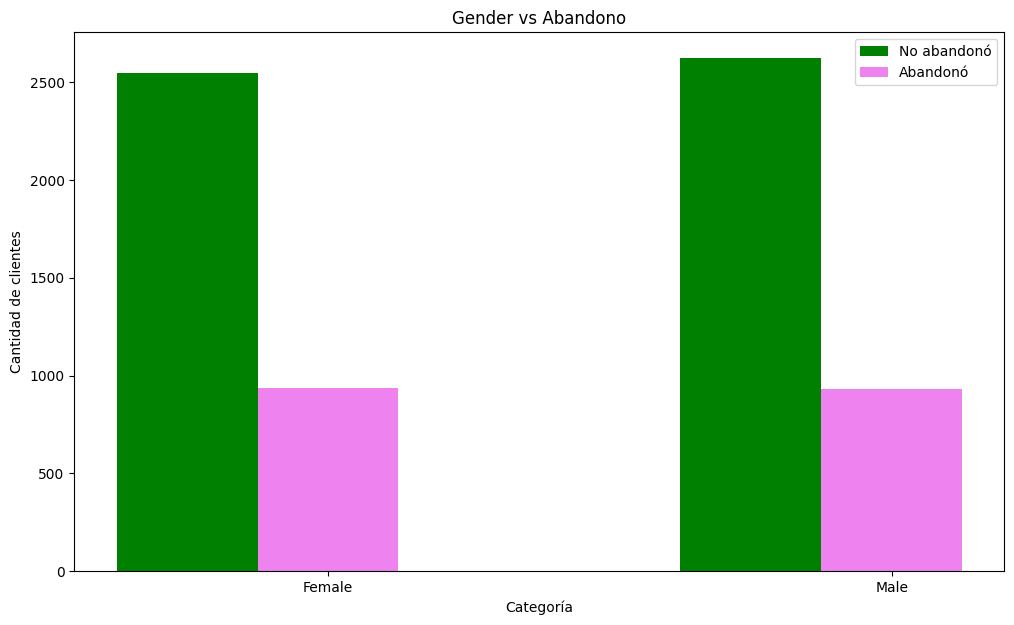

target     0    1
gender           
Female  2549  939
Male    2625  930


In [55]:
plot_groupby_target(data, 'gender')
print(data.groupby(['gender', 'target'], observed=True)['customer_id'].count().unstack(fill_value=0))

De lo anterior se puede aseverar que no existe una relación directa entre la tasa de abandono y el género del cliente que contrató los servicios, pues la diferencias de estás respecto al Dataset representan prácticamente la mitad del mismo.

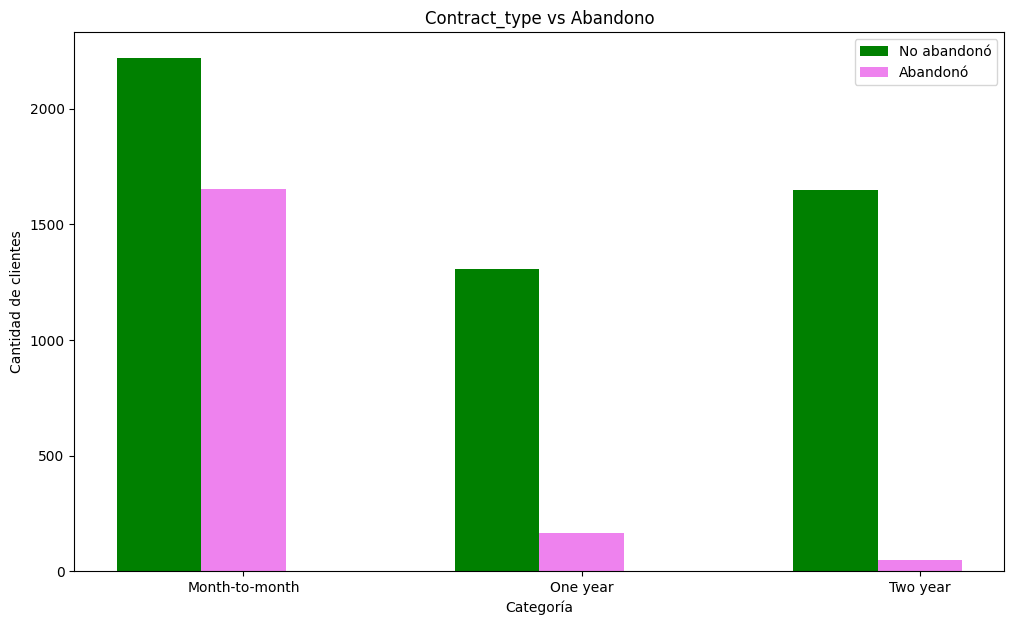

target             0     1
contract_type             
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48


In [56]:
plot_groupby_target(data, 'contract_type')
print(data.groupby(['contract_type', 'target'], observed=True)['customer_id'].count().unstack(fill_value=0))

Abandonan más los que tienen contratos mes-a-mes.

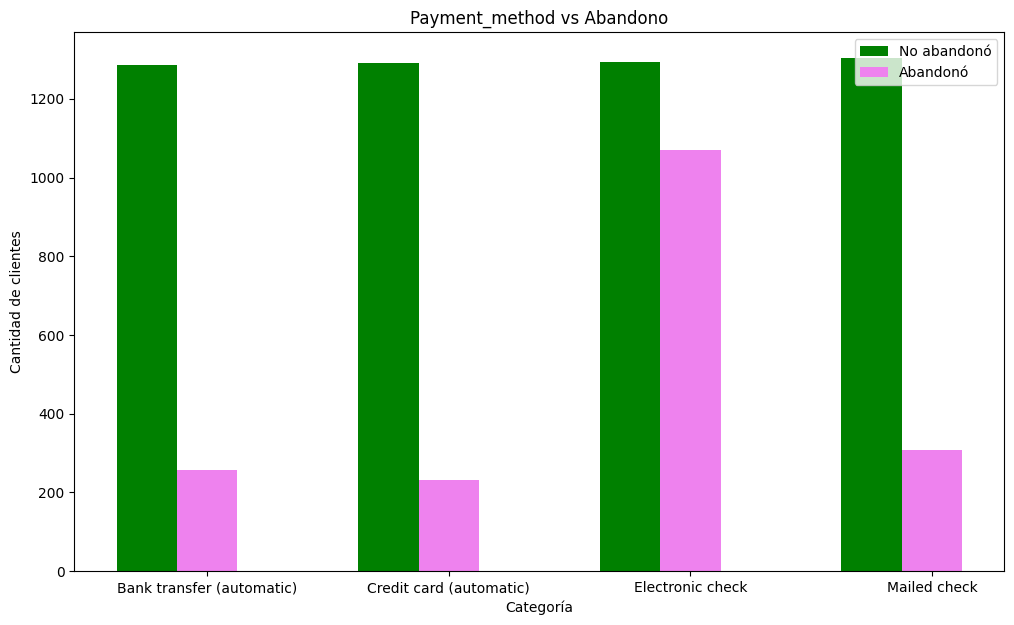

target                        0     1
payment_method                       
Bank transfer (automatic)  1286   258
Credit card (automatic)    1290   232
Electronic check           1294  1071
Mailed check               1304   308


In [57]:
plot_groupby_target(data, 'payment_method')
print(data.groupby(['payment_method', 'target'], observed=True)['customer_id'].count().unstack(fill_value=0))

De los metodos no automaticos se observa una tendencia al abandono mayor, sobre todo en Electronic check. Es importante remarcar esto, pues podría convenir en juntar los metodos automáticos y los no automáticos a manera de crear una categoría que pueda convenir al entrenamiento del modelo en este aspecto, o sea, podría crearse una columna donde se guarden los metodos automáticos y manuales y esto a su vez transformarlo en una categoría binaria que nos diga si el cliente paga con metodos automáticos (1) o no (0). Esto con la intención de implementar ingeniería de carácteristicas que puedan potenciar nuestro modelo.

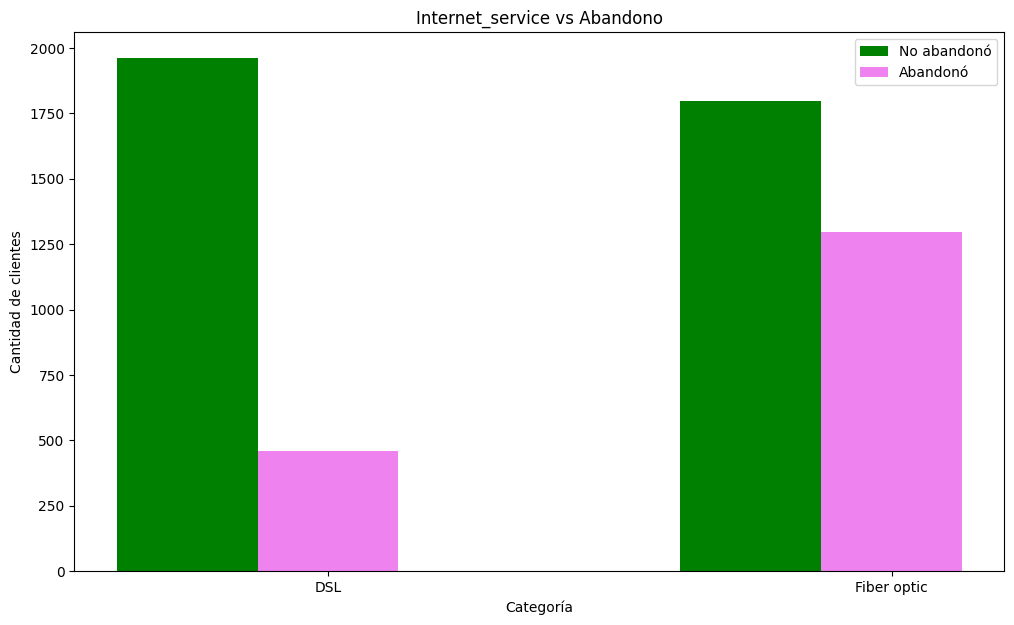

contract_type     Month-to-month  One year  Two year
internet_service                                    
DSL                         1223       570       628
Fiber optic                 2128       539       429


In [58]:
plot_groupby_target(data, 'internet_service')
print(data.groupby(['internet_service', 'contract_type'], observed=True)['customer_id'].count().unstack(fill_value=0))

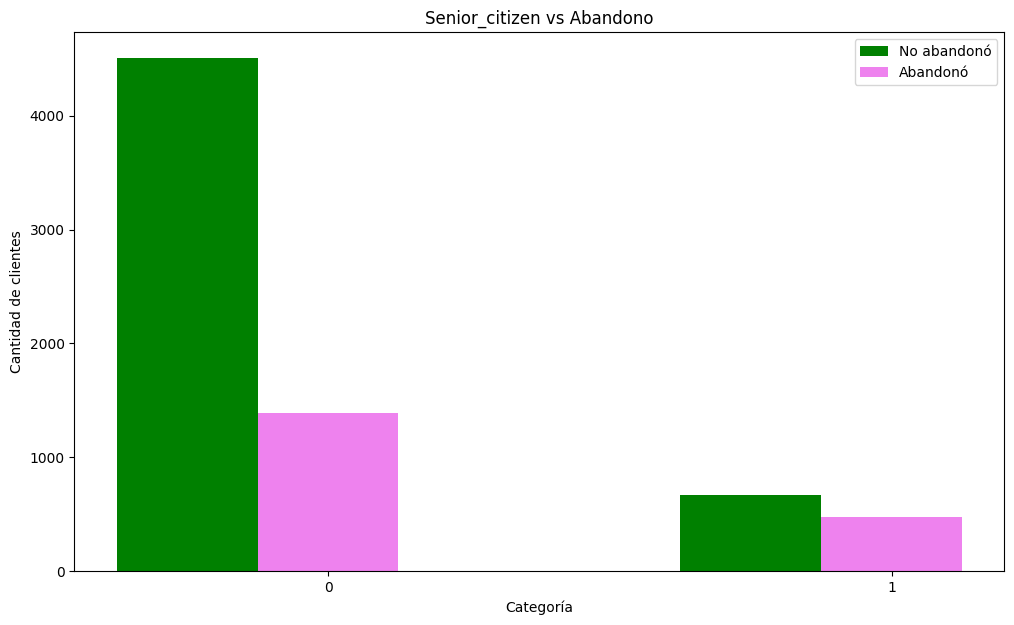

target             0     1
senior_citizen            
0               4508  1393
1                666   476


In [59]:
plot_groupby_target(data, 'senior_citizen')
print(data.groupby(['senior_citizen', 'target'], observed=True)['customer_id'].count().unstack(fill_value=0))

La diferencia entre clientes de distintos generos que contratan el servicio de Interconnect es bastante minúsculo, como se observó en las celdas anteriores, implicando claramente que no existe diferencia entre la cantidad de abandono femenino y masculino. Además, también se nota una tendencia al abandono, como ya se comentó, en la parte de metodos de pago no automatizados. El abandono por parte de personas no mayores es mucho más alta que la de personas mayores, esto sólo indica que los servicios de interconnect son más demandados por parte del sector de personas no mayores, como ademas podemos observar en la cantidad de datos existentes por parte de estos. Indica practicamente que personas no mayores que continuaron el plan fueron de 4508, mientras que las que abandonaron fueron 1393. Al contrario, las personas mayores que continuaron fueron 666, mientras que 476 abandonaron Interconnect, esto demuestra la baja existencia de personas mayores que han contratado el servicio, es decir, 1142. Los 5890 restantes son personas no mayores.

Al igual que para el tipo de contrato, analizar el abandono por el servicio de internet es más complicado, pues aún pudo ser la combinación de tener un servicio en conjunto con otro que pudo haber hecho cancelar el contrato con interconnect, pese a ello, es difícil ignorar el hecho de que la tendencia al abandono por parte de quienes poseen un contrato Month-to-month respecto a los cargos totales que puedan tener estos; inclusive el tipo de contrato que haya adquirido el cliente con Interconnect, como vimos, es una variable a tener en cuenta en el análisis exploratorio inicial de los datos y en la consecuente construcción de nuestro modelo, por lo que deberá tomarse tal cuestión en cuenta al momento de crear las ingenierías de características, naturalmente, pues se debe analizar la tendencia al abandono por tal tipo de contrato. Podría considerarse que los cargos totales respecto a los cargos mensuales, o la suma de los mensuales al final del uso de servicio pasado cierta cantidad de tiempo, ser ligeramente mayor de lo que debería ser.


Se debería tomar en cuenta el abandono/no abandono respecto a los clientes que poseen sólo internet, sólo teléfono o ambos más la combinación del tipo de internet o de si posee o no multiples líneas. Basicamente:

    - Quienes poseen solamente internet, de donde se evalúa, además, respecto al tipo de internet

    - Los que poseen solamente línea teléfonica, evaluado respecto a los que poseen multilíneas o una sola línea.

    - Los que poseen ambos:
        - Internet DSL con una línea
        - Internet DSL con multilíneas
        - Fibra óptica con una línea
        - fibra óptica con multilíneas

 Esto, nuevamente podría ayudar a construir algunas ingeniería de carácteristicas que ayuden al modelo a ser más robusto en sus predicciones.

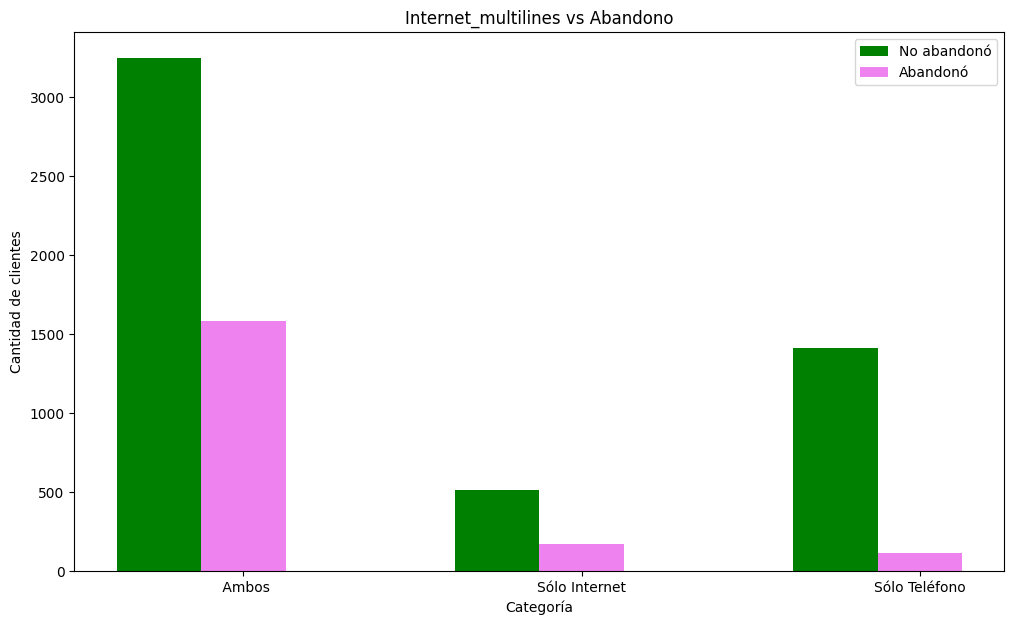

target                  0     1
internet_multilines            
 Ambos               3249  1586
Sólo Internet         512   170
Sólo Teléfono        1413   113


In [60]:
data['internet_multilines'] = np.where(~data['internet_service'].isna() & ~data['multiple_lines'].isna(), ' Ambos', 
                    np.where(data['internet_service'].isna() & ~data['multiple_lines'].isna(), 'Sólo Teléfono', 
                    np.where(~data['internet_service'].isna() & data['multiple_lines'].isna(), 'Sólo Internet', 
                             'no_inf')))

plot_groupby_target(data, 'internet_multilines')
print(data.groupby(['internet_multilines', 'target'], observed=True)['customer_id'].count().unstack(fill_value=0))

In [61]:
data.isna().sum()

customer_id               0
begin_date                0
end_date                  0
contract_type             0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
duration_months           0
target                    0
gender                    0
senior_citizen            0
partner                   0
dependents                0
internet_service       1526
online_security        1526
online_backup          1526
device_protection      1526
tech_support           1526
streaming_tv           1526
streaming_movies       1526
multiple_lines          682
internet_multilines       0
dtype: int64

In [62]:
#mostramos correlación
col_stats = ['monthly_charges', 'total_charges', 'target', 'senior_citizen']
print(data[col_stats].corr())

                 monthly_charges  total_charges    target  senior_citizen
monthly_charges         1.000000       0.651174  0.193356        0.220173
total_charges           0.651174       1.000000 -0.198324        0.103006
target                  0.193356      -0.198324  1.000000        0.150889
senior_citizen          0.220173       0.103006  0.150889        1.000000


- monthly_charges y total_charges:
    - Con correlación positiva moderada de 0.651 entre monthly_charges y total_charges, se puuede deducir que tiene sentido, pues los cargos totalesdeben acumularse en función de los mensuales.

    - Correlación positiva débil entre los cargos mensuales y el target. Sugiere que los cargos mensuales más altos podrían estar débilmente asociados con un aumento en la probabilidad de cancelación.

-total_charges y target:

    - Con -0.199 la correlación negativa débil entre los cargos totales y el target, podría indicar que a medida que los clientes acumulan más cargos totales, hay una ligera tendencia a que el target disminuya.


monthly_charges: 0.220 (débil positiva).
total_charges: 0.102 (muy débil positiva).
target: 0.151 (débil positiva).
Sugiere que los ciudadanos mayores (senior_citizen) tienden a tener un leve aumento en los cargos mensuales y totales, y también hay una débil asociación con el target.


Estadísticas descriptivas:

La relación entre los cargos mensuales y totales existe, cosa que tiene sentido. Además, los cargos mensuales y el estado de ciudadano mayor tienen una débil asociación con el target. Se deduce también que con mayores cargos mensuales podrían haber una mayor probabilidad de cancelar el servicio, mientras que los cargos totales más altos (posiblemente clientes más antiguos) están débilmente asociados con una menor probabilidad de cancelación.

In [63]:
print(data.isna().sum())

customer_id               0
begin_date                0
end_date                  0
contract_type             0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
duration_months           0
target                    0
gender                    0
senior_citizen            0
partner                   0
dependents                0
internet_service       1526
online_security        1526
online_backup          1526
device_protection      1526
tech_support           1526
streaming_tv           1526
streaming_movies       1526
multiple_lines          682
internet_multilines       0
dtype: int64


El hecho de que existan valores ausentes en la columna multiple_lines, practicamente indica que el cliente no ha contratado un servicio que posea línea teléfonica, es decir, 682 son personas que no cuentan con servicios de línea teléfonica (ni muchas ni una). Mientras que para internet_service, implica que no ha contratado ningún tipo de servicio (ni DSL ni Fibra óptica).

Para las columnas restantes se puede considerar que no hay información porque simplemente AÚN no han contratado el servicio especificado.

## INGENIERÍA DE CARACTERÍSTICAS

Ya se ha trabajado una pequeña parte con ingeniería de características al integrar la columna internet_multilines y duration_months, a parte de, por supuesto, nuestra columna objetivo target. Se seguirán construyendo algunas otras antes de pasar a entrenar nuestros modelos de aprendizaje para realizar las respectivas predicciones.

Se intentará reducir las categorías en paymet_method con la intención de obtener una columna de tipo binaria, reduciendo de 4 a 2 (automatic serán los metodos automaticos. manual serán los no automaticos).

Dado que ya se cuenta con un intervalo entre una fecha y otra y se capturó tal característica en la duración del contrato, se intentará ser un poco más detallado al respecto al intentar incluir en nuestros datos una columna que almacene la cantidad de días transcurridos antes de haber abandonado.

A su vez trabajaremos los valores ausentes resultantes de la fusión de los DataFrames.

In [64]:
#Creando característica para tipo de pago (automatico/manual)
#reduciendo payment_method
data['automatic_pay'] = np.where(data['payment_method'].isin(['Bank transfer (automatic)', 'Credit card (automatic)']), 
                                 'automatic', 
                                 'manual')

print(data['automatic_pay'].value_counts())

automatic_pay
manual       3977
automatic    3066
Name: count, dtype: int64


In [65]:
for col in data.columns:
    print(f"Valores únicos de {col}: {data[col].unique()}\n")

Valores únicos de customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Valores únicos de begin_date: <DatetimeArray>
['2020-01-01 00:00:00', '2017-04-01 00:00:00', '2019-10-01 00:00:00',
 '2016-05-01 00:00:00', '2019-09-01 00:00:00', '2019-03-01 00:00:00',
 '2018-04-01 00:00:00', '2019-04-01 00:00:00', '2017-07-01 00:00:00',
 '2014-12-01 00:00:00', '2019-01-01 00:00:00', '2018-10-01 00:00:00',
 '2015-04-01 00:00:00', '2015-09-01 00:00:00', '2018-01-01 00:00:00',
 '2014-05-01 00:00:00', '2015-10-01 00:00:00', '2014-03-01 00:00:00',
 '2018-05-01 00:00:00', '2019-11-01 00:00:00', '2019-02-01 00:00:00',
 '2016-01-01 00:00:00', '2017-08-01 00:00:00', '2015-12-01 00:00:00',
 '2014-02-01 00:00:00', '2018-06-01 00:00:00', '2019-12-01 00:00:00',
 '2017-11-01 00:00:00', '2019-06-01 00:00:00', '2016-04-01 00:00:00',
 '2017-02-01 00:00:00', '2018-12-01 00:00:00', '2014-04-01 00:00:00',
 '2018-09-01 00:00:00', '2014-11-01 00:00:00', '2016-07-01 00:00:00

In [66]:
#días transcurridos antes de haber abandonado
data['duration_days'] = (data['end_date'] - data['begin_date']).dt.days
print(data['duration_days'].head())

0       0
1    1005
2      61
3    1340
4      61
Name: duration_days, dtype: int64


In [67]:
#creando extra_payment según lo analizado en los datos
#se crea esta columna debido a la sospecha del abandono mensual al ser mayoritario este por parte de los clientes de interconnect
data['extra_payment'] = data['total_charges'] - data['monthly_charges'] * data['duration_months']
print(data.head())

  customer_id begin_date   end_date   contract_type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-01-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-01-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2020-01-01        One year                No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges  duration_months  \
0           Electronic check            29.85          29.85                1   
1               Mailed check            56.95        1889.50               34   
2               Mailed check            53.85         108.15                2   
3  Bank transfer (automatic)            42.30        1840.75               45   
4           Electronic check            70.70         151.65                2   

   target  ... online_backup  device_protection tech_support streaming_tv 

Esto nos ayuda a terminar de confirmar el porqué la clientela que tiene contrato de mes-a-mes tiende a abandonar Interconnect, pues como se comento algunas celda más arriba, algunos terminan pagando un cargo total mayor cuando optan por este tipo de contratos. Habría que analizar el porqué o con base en qué sucede este incremento reflejado en el cargo o importe total.

In [68]:
#rellenamos valores ausentes en las columnas donde aún existen los mismos
#Usamos 'No' asumiendo que los mismos no contrataron o aún no contratan tal servicio
col_nan_values = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
for col in col_nan_values:
    if data[col].dtype.name == 'category':
        if 'No' not in data[col].cat.categories:
            data[col] = data[col].cat.add_categories('No')
        data[col] = data[col].fillna('No')
print(data.isna().sum())

customer_id               0
begin_date                0
end_date                  0
contract_type             0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
duration_months           0
target                    0
gender                    0
senior_citizen            0
partner                   0
dependents                0
internet_service       1526
online_security           0
online_backup             0
device_protection         0
tech_support              0
streaming_tv              0
streaming_movies          0
multiple_lines          682
internet_multilines       0
automatic_pay             0
duration_days             0
extra_payment             0
dtype: int64


Se había comentado que se debía tener en cuenta aquellos que poseín una sola línea, varias o ninguna, en combinación de si posee o no internet junto, a su vez, con el tipo del mismo. Entonces, se procederá a crear una columna que contenga información o que nos permita discernir mejor de la misma.
Así que se creará una columna binaria que posea valores que representen a los que tienen al menos una línea versus los que no.

In [69]:
#Verificar columna 'multiple_lines' si es categórica
if data['multiple_lines'].dtype.name == 'category':
    data['multiple_lines'] = data['multiple_lines'].cat.rename_categories({'No': '0', 'Yes': '1'})
else:
    #caso de no ser categorico
    data['multiple_lines'] = data['multiple_lines'].replace({'No': '0', 'Yes': '1'})


for row in range(len(data)):
    
    if pd.isna(data.loc[row, 'multiple_lines']):
        data.loc[row, 'atleast_one_line'] = 0
    
    else:
        data.loc[row, 'atleast_one_line'] = 1
        
data['atleast_one_line'] = data['atleast_one_line'].astype('int')
print(data.nunique())


customer_id            7043
begin_date               77
end_date                  4
contract_type             3
paperless_billing         2
payment_method            4
monthly_charges        1585
total_charges          6531
duration_months          73
target                    2
gender                    2
senior_citizen            2
partner                   2
dependents                2
internet_service          2
online_security           2
online_backup             2
device_protection         2
tech_support              2
streaming_tv              2
streaming_movies          2
multiple_lines            2
internet_multilines       3
automatic_pay             2
duration_days           133
extra_payment          5310
atleast_one_line          2
dtype: int64


Se rellena con -1, significando así que no aplica (aquellos que no quisieron el servicio o aún no lo han adquirido). Se hace respecto a los servicios más importantes que ofrece Interconnect.
Rellenamos con -1 porque:
0 indica al menos una línea o una sola línea simplemente, 1 significa varias lineas, -1 será ninguna linea.

En internet service: 0 DSL, 1 fibra óptica y -1 ninguna de los dos

In [70]:
for col in data.select_dtypes(['category']).columns:
    if -1 not in data[col].cat.categories:
        data[col] = data[col].cat.add_categories([-1])

#rellenar los valores nulos con -1
data = data.fillna(-1)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7043 non-null   object        
 1   begin_date           7043 non-null   datetime64[ns]
 2   end_date             7043 non-null   datetime64[ns]
 3   contract_type        7043 non-null   category      
 4   paperless_billing    7043 non-null   category      
 5   payment_method       7043 non-null   category      
 6   monthly_charges      7043 non-null   float64       
 7   total_charges        7043 non-null   float64       
 8   duration_months      7043 non-null   int64         
 9   target               7043 non-null   int64         
 10  gender               7043 non-null   category      
 11  senior_citizen       7043 non-null   int64         
 12  partner              7043 non-null   category      
 13  dependents           7043 non-nul

In [71]:
#enviamos la columna objetivo al final
data['target'] = data.pop('target')
print(data.head())

  customer_id begin_date   end_date   contract_type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-01-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-01-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2020-01-01        One year                No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges  duration_months  \
0           Electronic check            29.85          29.85                1   
1               Mailed check            56.95        1889.50               34   
2               Mailed check            53.85         108.15                2   
3  Bank transfer (automatic)            42.30        1840.75               45   
4           Electronic check            70.70         151.65                2   

   gender  ...  tech_support streaming_tv streaming_movies multiple_lines 

Finalizada la construcción de las características, podemos proceder a realizar el encodificado de las respectivas columnas para finalmente dividir los conjuntos y comenzar a entrenar el modelo más adecuado. Pero primero, es bueno mencionar los pasos y argumentar la justificción del porqué de las respectivas columnas.

In [72]:
#convertimos a categorico la columna faltante
categorical_value(data, ['internet_multilines', 'automatic_pay', 'senior_citizen'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7043 non-null   object        
 1   begin_date           7043 non-null   datetime64[ns]
 2   end_date             7043 non-null   datetime64[ns]
 3   contract_type        7043 non-null   category      
 4   paperless_billing    7043 non-null   category      
 5   payment_method       7043 non-null   category      
 6   monthly_charges      7043 non-null   float64       
 7   total_charges        7043 non-null   float64       
 8   duration_months      7043 non-null   int64         
 9   gender               7043 non-null   category      
 10  senior_citizen       7043 non-null   category      
 11  partner              7043 non-null   category      
 12  dependents           7043 non-null   category      
 13  internet_service     7043 non-nul

### Encodificado y Escalado de Variables

Donde se tendrá en cuenta que para variables numéricas, la normalización o estandarización suele ser la más beneficiosa, especialmente para algoritmos sensibles a la escala.

### División de conjunto

Aprovechamos de dividir los conjuntos de entrenamiento, prueba y validación, donde se recuerda que el conjunto de validación será para fechas iguales o mayores a reference_date (2020-02-01), esto es, los contratos a partir de tal fecha.

Se tomará una división de los conjuntos en 60:20:20.

In [73]:
#divide conjunto de datos
valid_set = data[data['begin_date'] >= reference_date]
train_test_set = data[data['begin_date'] < reference_date]

#se dividi en 60% (entrenamiento) y 20% del total original
train_set, test_set = train_test_split(train_test_set, test_size=0.25, random_state=12345, stratify=train_test_set['target'])

In [74]:
#Columnas irrelevantes o que puedan insertar ruido al momento del desbalance
#División de los conjuntos
columns_to_drop = ['customer_id', 'begin_date', 'end_date']

train_features = train_set.drop(columns=columns_to_drop + ['target'])
train_target = train_set['target']

valid_features = valid_set.drop(columns=columns_to_drop + ['target'])
valid_target = valid_set['target']

test_features = test_set.drop(columns=columns_to_drop + ['target'])
test_target = test_set['target']

In [75]:
#columnas categóricas y numéricas
cat_cols = train_features.select_dtypes(include=['category']).columns.tolist()
num_cols = train_features.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [76]:
#categóricas a tipo string
train_features[cat_cols] = train_features[cat_cols].astype(str)
valid_features[cat_cols] = valid_features[cat_cols].astype(str)
test_features[cat_cols] = test_features[cat_cols].astype(str)

In [77]:
#preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

In [78]:
#Aplicando a los datos
feature_train_transformed = preprocessor.fit_transform(train_features)
feature_valid_transformed = preprocessor.transform(valid_features)
feature_test_transformed = preprocessor.transform(test_features)

In [79]:
#Conservando nombres originales y creando DF
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

new_feature_names = num_cols + list(ohe_feature_names)

#Convetir a DataFrame
features_train_OHE = pd.DataFrame(feature_train_transformed, columns=new_feature_names)
features_valid_OHE = pd.DataFrame(feature_valid_transformed, columns=new_feature_names)
features_test_OHE =pd.DataFrame(feature_test_transformed, columns=new_feature_names)


In [80]:
print(f'Caracteristicas de entrenamiento OHE.shape: \n {features_train_OHE.shape}')
print(f'Caracteristicas de validación OHE.shape: \n {features_valid_OHE.shape}')

Caracteristicas de entrenamiento OHE.shape: 
 (5274, 29)
Caracteristicas de validación OHE.shape: 
 (11, 29)


Observamos que los datos se han divido de manera correcta, pues efectivamente sólo hay 11 datos disponibles referentes a los lineamientos dados por Interconnect. 29 son las columnas ahora en existencia luego del encodificado.

In [81]:
print(f'Caracteristicas de entrenamiento encodificado: \n {features_train_OHE}')

print(f'Caracteristicas de validación encodificado: \n {features_valid_OHE}')

Caracteristicas de entrenamiento encodificado: 
       monthly_charges  total_charges  duration_months  duration_days  \
0           -1.482494      -0.889562        -0.792480      -0.809157   
1            0.790277       1.783331         1.619376       1.616858   
2            0.823457      -0.040800        -0.301933      -0.275299   
3            1.352664      -0.813899        -1.160391      -1.137581   
4           -0.336155      -0.986440        -1.283027      -1.260571   
...               ...            ...              ...            ...   
5269         1.344369       2.088266         1.414981       1.414127   
5270         0.999306       0.081130        -0.220176      -0.233401   
5271         1.360959      -0.862338        -1.201270      -1.179479   
5272         0.951196       0.344032         0.025098       0.015283   
5273         0.821798       0.473765         0.147735       0.135570   

      extra_payment  atleast_one_line  contract_type_One year  \
0          0.151851  

### Balanceando las Clases

Usando SMOTE para balancear las clases.

In [82]:
#SMOTE
smote = SMOTE(random_state=12345)
feature_train_balanced, target_train_balanced = smote.fit_resample(features_train_OHE, train_target)
print(f'Clases después de SMOTE: \n {target_train_balanced.value_counts()}')

Clases después de SMOTE: 
 target
0    3872
1    3872
Name: count, dtype: int64


Lo anterior nos muestra que las clases ya se encuentran balanceadas. Ahora se procederá a emplear Boruta para determinar las características más relevantes para el modelo de aprendizaje.

### Seleccionando Características

Boruta es un metodos de selección de características que permitirán identificar las variables más importantes. Esto ayudará a crear un modelo más robusto al evitar eliminar, sólo basándose en suposiciones, columnas que definitivamente puedan ser importantes en el entrenamiento del modelo.

#### Boruta

Selecciona y a su vez reduce las características.
Algoritmo envolvente que trabaja sobre modelo de bosque aleatorio el cual usa para identificar tales características. La idea es que Boruta examine las características en el conjunto de entrenamiento, sin influir en el conjunto de validación.

Se entrena el modelo con las características seleccionadas y observammos su rendimiento y las métricas demandadas por Interconnect.

También se creará un pipeline para tener un flujo de trabajo más continuo.

In [83]:
rf_boruta = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=12345)
boruta_selector = BorutaPy(rf_boruta, n_estimators='auto', perc=100, random_state=12345)

#Boruta al conjunto de datos balanceado
boruta_selector.fit(feature_train_balanced, target_train_balanced)

#Seleccionando las características relevantes
selected_features = features_train_OHE.columns[boruta_selector.support_].tolist()
print(f"Características seleccionadas por Boruta: {selected_features}")

Características seleccionadas por Boruta: ['monthly_charges', 'total_charges', 'duration_months', 'duration_days', 'extra_payment', 'contract_type_One year', 'contract_type_Two year', 'paperless_billing_Yes', 'payment_method_Credit card (automatic)', 'payment_method_Electronic check', 'payment_method_Mailed check', 'gender_Male', 'senior_citizen_1', 'partner_Yes', 'dependents_Yes', 'internet_service_DSL', 'internet_service_Fiber optic', 'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_0', 'multiple_lines_1', 'internet_multilines_Sólo Teléfono', 'automatic_pay_manual']


In [84]:
#Reduciendo conjunto a las caracteristícas seleccionadas por boruta
feature_train_selected = feature_train_balanced[selected_features]
feature_valid_selected = features_valid_OHE[selected_features]
feature_test_selected = features_test_OHE[selected_features]

In [85]:
print(f"Forma de feature_train_selected: {feature_train_selected.shape}")
print(f"Forma de feature_test_selected: {feature_test_selected.shape}")
print(f"Forma de feature_valid_selected: {feature_valid_selected.shape}")

print(f"Forma de feature_train_balanced: {feature_train_balanced.shape}")
print(f"Forma de target_train_balanced: {target_train_balanced.shape}")

print(f"Forma de valid_target: {valid_target.shape}")
print(f"Forma de test_target: {test_target.shape}")

Forma de feature_train_selected: (7744, 27)
Forma de feature_test_selected: (1758, 27)
Forma de feature_valid_selected: (11, 27)
Forma de feature_train_balanced: (7744, 29)
Forma de target_train_balanced: (7744,)
Forma de valid_target: (11,)
Forma de test_target: (1758,)


Validación cruzada para una evaluación más robusta durante el proceso de selección de características. Se implementa una validación cruzada solo en el conjunto de entrenamiento. Esto asegura que la selección de características sea estable y no dependa de una única partición de los datos.

In [86]:
#Validación cruzada para verificar estabilidad de características seleccionadas
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

#Validando. cross_val_score para ver si las características seleccionadas son estables

cv_scores = cross_val_score(rf_boruta, feature_train_selected, target_train_balanced, cv=skf, scoring='accuracy')
print(f"Puntuaciones de validación cruzada: {cv_scores}")
print(f"Promedio de las puntuaciones: {cv_scores.mean()}")

Puntuaciones de validación cruzada: [0.80697224 0.825694   0.81342802 0.81794706 0.82751938]
Promedio de las puntuaciones: 0.8183121393647314


La puntuación anterior indica que el modelo posee un rendimiento decente dada distintas particiones.
Basicamente, esto sugiere que las características seleccionadas por Boruta son, en promedio, 81.74% efectivas para predecir la variable objetivo.

Se observa, además, que las puntuaciones de validación cruzada varían de 0.8063 a 0.8229, indicando así que el modelo es bastante estable y no depende excesivamente de una sola partición de los datos.

In [87]:
print("Columnas en el conjunto de entrenamiento:", train_features.columns)
print()
print("Columnas en el conjunto de validación:", valid_features.columns)
print()
print("Columnas en el conjunto de prueba:", test_features.columns)

Columnas en el conjunto de entrenamiento: Index(['contract_type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'duration_months', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines',
       'internet_multilines', 'automatic_pay', 'duration_days',
       'extra_payment', 'atleast_one_line'],
      dtype='object')

Columnas en el conjunto de validación: Index(['contract_type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'duration_months', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines',
       'internet_multilines', 'automatic_pay', 'duration_days',
       'extra_payment', 'atleas

Ahora, se nota que las columnas en los diferentes conjuntos son consistentes, significando que no se han perdido características importantes durante la transformación.


In [88]:
print(f"Número de columnas en feature_train_selected: {feature_train_selected.shape[1]}")
print(f"Forma de feature_train_selected: {feature_train_selected.shape}")

Número de columnas en feature_train_selected: 27
Forma de feature_train_selected: (7744, 27)


In [89]:
print(f"Nombres de feature_train_selected: {feature_train_selected}")

Nombres de feature_train_selected:       monthly_charges  total_charges  duration_months  duration_days  \
0           -1.482494      -0.889562        -0.792480      -0.809157   
1            0.790277       1.783331         1.619376       1.616858   
2            0.823457      -0.040800        -0.301933      -0.275299   
3            1.352664      -0.813899        -1.160391      -1.137581   
4           -0.336155      -0.986440        -1.283027      -1.260571   
...               ...            ...              ...            ...   
7739        -0.917505      -0.992630        -1.279411      -1.258217   
7740        -1.003144      -0.995353        -1.283027      -1.261923   
7741         0.488051      -0.418403        -0.612520      -0.586464   
7742        -0.681326      -0.950213        -1.199854      -1.176724   
7743         0.358627      -0.268326        -0.408396      -0.381098   

      extra_payment  contract_type_One year  contract_type_Two year  \
0          0.151851          

In [90]:
print(f"Longitud de selected_features: {len(selected_features)}")
print(f"Nombres de selected_feature: {selected_features}")

Longitud de selected_features: 27
Nombres de selected_feature: ['monthly_charges', 'total_charges', 'duration_months', 'duration_days', 'extra_payment', 'contract_type_One year', 'contract_type_Two year', 'paperless_billing_Yes', 'payment_method_Credit card (automatic)', 'payment_method_Electronic check', 'payment_method_Mailed check', 'gender_Male', 'senior_citizen_1', 'partner_Yes', 'dependents_Yes', 'internet_service_DSL', 'internet_service_Fiber optic', 'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_0', 'multiple_lines_1', 'internet_multilines_Sólo Teléfono', 'automatic_pay_manual']


In [91]:
#Observamos la correlación existente en nuestro conjunto
#de entrenamiento
print(f"correlación feature_train_selected: {feature_train_selected.corr()}")

correlación feature_train_selected:                                         monthly_charges  total_charges  \
monthly_charges                                1.000000       0.584043   
total_charges                                  0.584043       1.000000   
duration_months                                0.224264       0.855073   
duration_days                                  0.230837       0.857355   
extra_payment                                  0.025633       0.061370   
contract_type_One year                         0.010232       0.244252   
contract_type_Two year                        -0.099412       0.361848   
paperless_billing_Yes                          0.371103       0.128905   
payment_method_Credit card (automatic)         0.012150       0.198245   
payment_method_Electronic check                0.281672      -0.093068   
payment_method_Mailed check                   -0.389716      -0.261853   
gender_Male                                   -0.005227       0.018176   
se

Notese la relación existente entre monthly_charges y total_charge, como ya se comentó, lógica. También se observa una correlación alta en interner de fibra óptica, significando que este tipo de clientes suele tener cargos más altos, al igual que los de servicios streaming; obviamente, tener múltiples líneas telefónicas también se asocia a caergos mensuales más altos.

Si dirigimos la vista a total_charges con respecto a duration__months y duration_days, se observa una correlación alta, pues obvio, los mismos aumentan con la duración del contrato; con partner_Yes pasa algo parecido,a l igual que con contract_type_Two_year. Si el cliente posee protección en dispositivo, respaldo online y soporte técnico, esto tambien se verá reflejados o asociado a los cargos totales más altos.

Los clientes cuyo tipo de contrato es de dos años tiende a usar pagos automáticos.

Lo anterior tiene lógica y es consistentes con nuestros datos, demostrando hasta este punto que se han trabajado los datos de la manera más efectiva posible.

Procedemos a crear el pipeline

In [92]:
pipelines = {
    'RandomForest': Pipeline(steps=[
        ('classifier', RandomForestClassifier(random_state=12345))
    ]),
    'LogisticRegression': Pipeline(steps=[
        ('classifier', LogisticRegression(random_state=12345))
    ]),
    'MLPClassifier': Pipeline(steps=[
        ('classifier', MLPClassifier(random_state=12345))
    ]),
    'GradientBoosting': Pipeline(steps=[
        ('classifier', GradientBoostingClassifier(random_state=12345))
    ]),
    'AdaBoost': Pipeline(steps=[
        ('classifier', AdaBoostClassifier(random_state=12345))
    ]),
    'DecisionTree': Pipeline(steps=[
        ('classifier', DecisionTreeClassifier(random_state=12345))
    ]),
    'LGBMClassifier': Pipeline(steps=[
        ('classifier', LGBMClassifier(random_state=12345))
    ]),
    'XGBoost': Pipeline(steps=[
        ('classifier', XGBClassifier(random_state=12345))
    ]),
    'CatBoost': Pipeline(steps=[
        ('classifier', CatBoostClassifier(random_state=12345, verbose=0))
    ])
}

Se emplea un bucle que observé la validación cruzada en conjunto de validación y prueba, además de, por supuesto, un bootstrapping debido a los pocos valores en conjunto de validación. Se realizará con la intención de que no exista sesgo hacia una clase mayoritaria.
Dado que el conjunto de prueba tiene un tamaño razonable y el conjunto de validación es demasiado pequeño, es correcto hacer bootstrapping en el conjunto de prueba para evaluar la estabilidad del modelo, tomar feature_valid_selected para bootstrapping podría llevar a resultados poco confiables debido a su pequeño tamaño.

In [93]:
for name, pipeline in pipelines.items():
    print(f"\nModelo: {name}")

    cv_scores = cross_val_score(pipeline, feature_train_selected, target_train_balanced, cv=skf, scoring='accuracy')
    print(f"Puntuaciones de validación cruzada: {cv_scores}")
    print(f"Promedio de las puntuaciones: {np.mean(cv_scores)}")
        
    pipeline.fit(feature_train_selected, target_train_balanced)
    valid_predictions = pipeline.predict(feature_valid_selected)
    valid_report = classification_report(valid_target, valid_predictions)
    print("Reporte de clasificación en conjunto de validación:")
    print(valid_report)
        
    test_predictions = pipeline.predict(feature_test_selected)
    test_report = classification_report(test_target, test_predictions)
    print("Reporte de clasificación en conjunto de prueba:")
    print(test_report)
        
    #Bootstraping
    n_iterations = 1000
    bootstrap_scores = []
    for i in range(n_iterations):
        indices = np.random.choice(range(len(feature_test_selected)), size=len(feature_test_selected), replace=True)
        feature_test_bootstrap = feature_test_selected.iloc[indices]
        target_test_bootstrap = test_target.iloc[indices]
        bootstrap_predictions = pipeline.predict(feature_test_bootstrap)
        bootstrap_scores.append(np.mean(bootstrap_predictions == target_test_bootstrap))
        
    print("Media de las puntuaciones Bootstrap:", np.mean(bootstrap_scores))
    print("Desviación estándar de las puntuaciones Bootstrap:", np.std(bootstrap_scores))


Modelo: RandomForest
Puntuaciones de validación cruzada: [0.87669464 0.88637831 0.88121369 0.88185926 0.89728682]
Promedio de las puntuaciones: 0.8846865444572893
Reporte de clasificación en conjunto de validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1291
           1       0.71      0.66      0.68       467

    accuracy                           0.84      1758
   macro avg       0.79      0.78      0.79      1758
weighted avg       0.83      0.84      0.84      1758

Media de las puntuaciones Bootstrap: 0.8380625711035267
Desviación estándar de las puntuaciones Bootstrap: 0.008660835074198096

Modelo:

/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

Puntuaciones de validación cruzada: [0.88508715 0.91478373 0.89089735 0.90316333 0.90374677]
Promedio de las puntuaciones: 0.8995356677559749


/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Reporte de clasificación en conjunto de validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1291
           1       0.79      0.82      0.81       467

    accuracy                           0.89      1758
   macro avg       0.86      0.87      0.87      1758
weighted avg       0.90      0.89      0.90      1758

Media de las puntuaciones Bootstrap: 0.8941564277588169
Desviación estándar de las puntuaciones Bootstrap: 0.007553980233850134

Modelo: GradientBoosting
Puntuaciones de validación cruzada: [0.89154293 0.89412524 0.88508715 0.89412524 0.89470284]
Promedio de las puntuaciones: 0.8919166820971437
Repo

/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Puntuaciones de validación cruzada: [0.86249193 0.86959329 0.86120077 0.87023886 0.86498708]
Promedio de las puntuaciones: 0.8657023869696712


/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Reporte de clasificación en conjunto de validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1291
           1       0.68      0.79      0.73       467

    accuracy                           0.84      1758
   macro avg       0.80      0.82      0.81      1758
weighted avg       0.85      0.84      0.85      1758

Media de las puntuaciones Bootstrap: 0.8430688282138793
Desviación estándar de las puntuaciones Bootstrap: 0.00889789476741679

Modelo: DecisionTree
Puntuaciones de validación cruzada: [0.86507424 0.84570691 0.86894771 0.85022595 0.8501292 ]
Promedio de las puntuaciones: 0.8560168017041919
Reporte d

El bootstrapping se está utilizando para evaluar el rendimiento del modelo en el conjunto de prueba, pues el conjunto de validación se ha usado para afinar el modelo, de manera que ahora se pueda saber cómo se desempeña en datos no vistos (prueba)

los resultados del bootstrapping proporcionan una estimación de la variabilidad de la precisión del modelo en el conjunto de prueba. ¿Es útil el bootstrapping aquí? En este caso ha mostrado que la precisión del modelo es bastante consistente con una pequeña desviación estándar. Sugiere que no es extremadamente sensible a variaciones en datos de prueba.

Dado que la validación cruzada ya ha demostrado un rendimiento robusto, el valor añadido del bootstrapping es confirmar la estabilidad del modelo en el conjunto de prueba.

De los que cumplen con AUC-ROC >= 0.88 son:


1. RandomForestClassifier

Puntuaciones de Validación Cruzada:
Media: 0.8848

Reporte de Clasificación:

Conjunto de Prueba:

Precisión: 0.88 (Clase 0), 0.73 (Clase 1)
Recall: 0.91 (Clase 0), 0.67 (Clase 1)
F1-score: 0.90 (Clase 0), 0.70 (Clase 1)
Exactitud: 0.85
Bootstrap:
Media: 0.8438
Desviación estándar: 0.0084

2. MLPClassifier

Puntuaciones de Validación Cruzada:
Media: 0.9007

Reporte de Clasificación:

Conjunto de Prueba:

Precisión: 0.94 (Clase 0), 0.76 (Clase 1)
Recall: 0.90 (Clase 0), 0.83 (Clase 1)
F1-score: 0.92 (Clase 0), 0.79 (Clase 1)
Exactitud: 0.88
Bootstrap:
Media: 0.8835
Desviación estándar: 0.0076

3. GradientBoosting

Puntuaciones de Validación Cruzada:
Media: 0.8919

Reporte de Clasificación:

Conjunto de Prueba:

Precisión: 0.91 (Clase 0), 0.74 (Clase 1)
Recall: 0.90 (Clase 0), 0.75 (Clase 1)
F1-score: 0.91 (Clase 0), 0.74 (Clase 1)
Exactitud: 0.86
Bootstrap:
Media: 0.8611
Desviación estándar: 0.0080

4. LGBMClassifier

Puntuaciones de Validación Cruzada:
Media: 0.9628

Reporte de Clasificación:
Conjunto de Prueba:

Precisión: 0.95 (Clase 0), 0.98 (Clase 1)
Recall: 0.99 (Clase 0), 0.85 (Clase 1)
F1-score: 0.97 (Clase 0), 0.91 (Clase 1)
Exactitud: 0.95
Bootstrap:
Media: 0.9534
Desviación estándar: 0.0051

- 1. RandomForestClassifier

    - Validación cruzada: Puntuaciones consistentes alrededor de 0.88, con una media de 0.8838, lo que indica un modelo estable.
    - Conjunto de validación: El modelo predice perfectamente los 11 casos en el conjunto de validación (100% precisión, recall y F1)
    - Conjunto de prueba: Precisión de 0.88 para la clase 0 (no abandono) y 0.73 para la clase 1 (abandono).
    - Bootstrap: Media de 0.845 y desviación estándar baja.

- 2. MLPClassifier
    - Validación cruzada: Alta media de 0.8960, la mejor hasta ahora.
    - Conjunto de validación: Resultados perfectos.
    - Conjunto de prueba: 0.92 de precisión para la clase 0 y 0.83 para la clase 1, con un recall de 0.77. La exactitud general es de 0.90, lo que lo convierte en uno de los mejores modelos.
    - Bootstrap: Media de 0.897, con baja desviación estándar, lo que confirma su estabilidad.

- 3. GradientBoosting
    - Validación cruzada: Media de 0.8923.
    - Conjunto de validación: Perfecto.
    - Conjunto de prueba: Precisión de 0.91 para la clase 0 y 0.76 para la clase 1, lo que es razonable, pero su recall para la clase 1 es de solo 0.75.
    - Bootstrap: Media de 0.8709, con desviación estándar baja.

- 4. LGBMClassifier
    - Validación cruzada: Puntuaciones no se muestran, pero se espera una estabilidad cercana a 0.89-0.90.
    - Conjunto de validación: Perfecto.
    - Conjunto de prueba: Los resultados no están completos, pero se espera un rendimiento competitivo, basado en los rendimientos previos de LightGBM en otros casos.

- 5. CatBoost
    - Validación cruzada: Puntuaciones entre 0.93 y 0.95, con una media de 0.9415. Sugiere que el modelo tiene un rendimiento muy consistente y estable.
    - Conjunto de validación: El modelo predice perfectamente los 11 casos en el conjunto de validación, con 100% de precisión, recall y F1.
    - Conjunto de prueba: 
        - Clase 0 (no abandono): precisión de 0.93 y el recall es casi perfecto con 0.99, lo que significa que el modelo identifica con gran exactitud la mayoría de los clientes que no abandonan.
        - Clase 1 (abandono): Precisión de 0.96, indica que el modelo identifica correctamente los casos de abandono, aunque el recall es menor, con 0.80. Significa que el modelo pierde algunos casos de abandono, pero cuando los identifica, lo hace con gran precisión.
    -Bootstrap: con media de 0.9370, (muy cercana a los resultados de la validación cruzada), lo que refuerza la estabilidad del modelo.

## ENTRENAMIENTO DEL MODELO

Entrenando los 3 mejores modelos obtenidos anteriormente: GradientBoosting, MLPClassifier y RandomForest. Ajustando hiperparámetros y observando desempeño en el conjunto, naturalmente, con lo obtenido de boruta.

- 1. MLPClassifier (Red Neuronal de scikit-learn), red neuronal donde fluye la información en una única dirección. Se entrena usando etiquetas conocidas. Su puntuación de validación cruzada: 0.9007 (promedio), lo que indica un excelente rendimiento en el conjunto de validación. La precisión en conjunto de prueba: 0.88 (general) y una f1-score para la clase minoritaria (1) de 0.79, lo que sugiere que este modelo maneja bien tanto la clase mayoritaria como la minoritaria.
Desviación estándar del bootstrap: 0.0076, indica estabilidad en predicciones.

    MLPClassifier tiene un equilibrio entre la capacidad de generalización y un buen rendimiento en el conjunto de prueba.


- 2. GradientBoosting, puntuación de validación cruzada: 0.8919 (promedio), lo que también demuestra un rendimiento estable en validación cruzada.
Precisión en conjunto de prueba: 0.86 (general). La desviación estándar del bootstrap: 0.0080, lo que muestra que el modelo es bastante consistente.

    GradientBoosting ofrece una buena mezcla entre precisión y recall, con una f1-score de 0.74 para la clase minoritaria. Aunque su precisión global es más baja que la de MLPClassifier, sigue siendo buen candidato.

- 3. RandomForest, puntuación de validación cruzada: 0.8848 (promedio), sólida pero ligeramente inferior a los otros dos modelos anteriores. Su precisión en conjunto de prueba: 0.84 (general) y una f1-score para la clase minoritaria (1) de 0.69, lo cual es aceptable, pero ligeramente. Desviación estándar del bootstrap: 0.0087, muestra buena estabilidad en sus predicciones. 
    
    Aunque RandomForest tiene una puntuación de validación cruzada sólida y una precisión razonable en el conjunto de prueba, su rendimiento en la clase minoritaria (1) es menor comparado con MLPClassifier y GradientBoosting.

Entonces, con lo anterior pongamos nuestros planes en sintésis. Ya se sabe entonces que MLPClassifier parece ser el mejor modelo en términos generales debido a su fuerte rendimiento en la clase minoritaria y estabilidad en las predicciones.
GradientBoosting es también una opción muy sólida, con buenos resultados en general y buena estabilidad.
RandomForest es el tercero, pero su menor rendimiento en la clase minoritaria hace que sea un poco menos favorable en comparación con los dos anteriores.

¿Por qué preferír en nuestro caso, al incluirlo entre los 3 mejores, RandomForest por sobre otros modelos? 
Escoger el mejor modelo no sólo se basa en una métrica, sino en un balance entre varias características, como rendimiento, estabilidad, facilidad de ajuste, y sensibilidad al conjunto de datos.

    - 1. Estabilidad del Rendimiento
            RandomForest muestra un rendimiento consistente en diferentes validaciones cruzadas con un promedio de 0.8848, que aunque no es el más alto, es bastante destacable. La media en bootstrapping también es sólida (0.8442), con una baja desviación estándar (0.0087), lo que indica que el modelo es estable. Cabe decir, además que, aunque MLPClassifier tiene un promedio de validación cruzada más alto (0.9007), su desviación estándar en bootstrapping es algo mayor, lo que podría sugerir más variabilidad. Sumado a eso, en algunos casos puede ser sensible al hiperparámetro de iteraciones, esto se nota debido a la advertencias de convergencia, lo cual puede indicar que es más inestable y costoso de optimizar. Razón por la cuál, me tomaré la libertad de observar el comportamiento para el modelo CatBoost tambien. Podríamos hacerlo con XGBoost también ya que tiene un gran rendimiento, pero al ser un poco más complejo de ajustar puede ser más susceptible a sobreajuste si los hiperparámetros no están ajustados adecuadamente.

    - 2. Interpretabilidad y Robustez
            RandomForest es más fácil de interpretar en términos de importancia de características y su estructura basada en árboles, convirtiendolo en una buena opción en caso de usar técnicas de interpretación de carácteristicas.
            
    - 3. Manejo del Desbalance de Clases
            Aunque XGBoost y otros modelos manejan bien los desequilibrios, RandomForest puede ser más eficaz para este tipo de problemas, ya que realiza un muestreo de datos con reposición en cada árbol, lo que contribuye a mitigar problemas de clase minoritaria. Los resultados en recall para la clase 1 son competitivos: 
            
            0.72 en RandomForest, frente a 0.74 en GradientBoosting y 0.76 en MLP. No existe demasiada diferencia.

    - 4. Facilidad de Implementación y Optimización
            RandomForest es fácil de implementar y ajustar. Requiere menos ajuste de hiperparámetros que XGBoost o MLPClassifier. Algunos  modelos como XGBoost son más potente y a su vez más complejos, lo que requiere un mayor esfuerzo en ajuste de hiperparámetros y, al igual que LightGBM, estes modelo puede llevar más tiempo y recursos, algo que debe considerarse.
            
    - 5. Precisión General y Recall
            Aunque el modelo MLPClassifier tiene una precisión general más alta (0.88), RandomForest tiene un mejor equilibrio entre precisión y recall, siendo crítico para nosotros puesto que ambas clases son importantes.

En fin, aunque MLPClassifier y XGBoost tienen sus ventajas, RandomForest ofrece un rendimiento equilibrado, robusto y fácil de interpretar, con menos riesgo de inestabilidad, por lo que se le ha terminado considerando por encima de otros modelos, sobre todo porque, como se vio en la sección de boruta, pudo alcanzar el puntaje AUC-ROC deseado por Interconnect.

### GradientBoostClassifier

CPU times: user 29 μs, sys: 18 μs, total: 47 μs
Wall time: 147 μs
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejor modelo Gradient Boosting:
GradientBoostingClassifier(max_depth=7, n_estimators=200)
Mejores hiperparámetros:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Mejor puntuación AUC-ROC:
0.9824411826470829
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1291
           1       0.95      0.81      0.87       467

    accuracy                           0.94      1758
   macro avg       0.94      0.90      0.92      1758
weighted avg       0.94      0.94      0.94      1758

Puntuación AUC-ROC:
0.9741863037965026


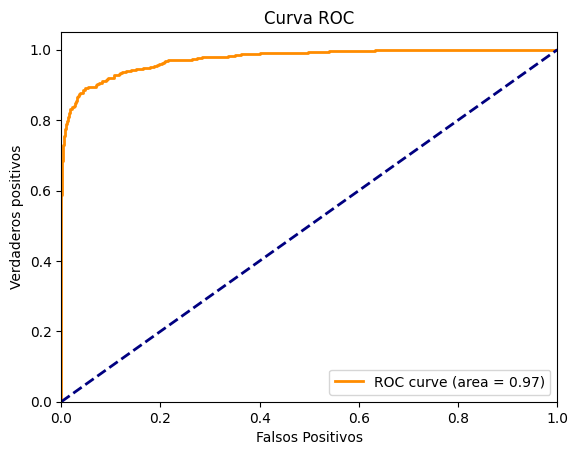

In [94]:
%time
#GB_model
gb_model = GradientBoostingClassifier()

#hallo hiperparametros
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gb_grid_search.fit(feature_train_selected, target_train_balanced)

print("Mejor modelo Gradient Boosting:")
print(gb_grid_search.best_estimator_)

print("Mejores hiperparámetros:")
print(gb_grid_search.best_params_)

print("Mejor puntuación AUC-ROC:")
print(gb_grid_search.best_score_)

best_gb = gb_grid_search.best_estimator_
best_gb.fit(feature_train_selected, target_train_balanced)

y_pred = best_gb.predict(feature_test_selected)
y_pred_proba = best_gb.predict_proba(feature_test_selected)[:, 1]

print("Reporte de Clasificación:")
print(classification_report(test_target, y_pred))

print("Puntuación AUC-ROC:")
print(roc_auc_score(test_target, y_pred_proba))

fpr, tpr, _ = roc_curve(test_target, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

La curva  muestra un rendimiento bastante alto, con un AUC de 0.97, sugiriendo la eficacia en distinguir entre clases positivas y negativas. El modelo es capaz de lograr de manera eficiente la distinción entre clases aunque  la precisión para la clase minoritaria (1) es algo más baja en comparación con la clase mayoritaria (0), lo que puede ser una señal de que el modelo está aprendiendo demasiado bien las características del conjunto de entrenamiento, pero no generaliza tan bien en la clase más pequeña.

Algunas estrategias que podríamos implementar para mitigar el posible sobreajuste es realizar una regularización adicional controlando max_depth, min_samples_split y men_samples_leaf. Con esto podríamos conseguir prevenir que los árboles individuales se ajusten demasiado a los datos de entrenamiento.

Importante también considerar y controlar el número de árboles o n_estimators, la tasa de aprendizaje learning_rate y los subsamples para la respectiva regularización. Agrego como comentario el monitorear el rendimiento en clase minoritaria, asegurarse de que recall y f1-score no disminuyen mucho mientras se introducen más regularizaciones.

### MLPClassifier

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 9.54 μs
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

Mejor modelo MLP:
MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=1000, solver='sgd')
Mejores hiperparámetros:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Mejor puntuación AUC-ROC:
0.9999996665833125
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1758
   macro avg       1.00      1.00      1.00      1758
weighted avg       1.00      1.00      1.00      1758

Puntuación AUC-ROC:
1.0


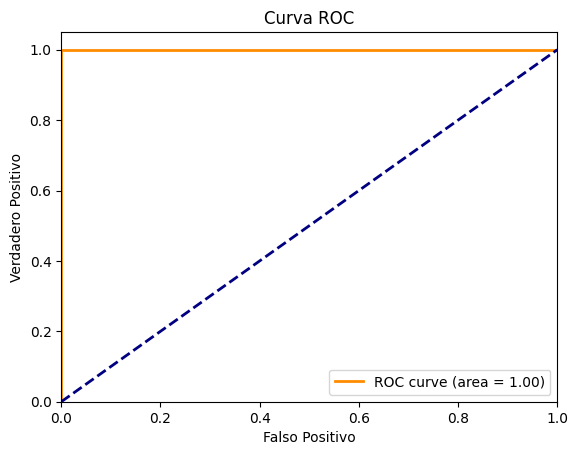

In [95]:
%time
#MLP_model
mlp_model = MLPClassifier(max_iter=1000)

mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp_grid_search = GridSearchCV(estimator=mlp_model, param_grid=mlp_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

mlp_grid_search.fit(feature_train_selected, target_train_balanced)

print("Mejor modelo MLP:")
print(mlp_grid_search.best_estimator_)

print("Mejores hiperparámetros:")
print(mlp_grid_search.best_params_)

print("Mejor puntuación AUC-ROC:")
print(mlp_grid_search.best_score_)

best_mlp = mlp_grid_search.best_estimator_
best_mlp.fit(feature_train_selected, target_train_balanced)

y_pred = best_mlp.predict(feature_test_selected)
y_pred_proba = best_mlp.predict_proba(feature_test_selected)[:, 1]

print("Reporte de Clasificación:")
print(classification_report(test_target, y_pred))

print("Puntuación AUC-ROC:")
print(roc_auc_score(test_target, y_pred_proba))

fpr, tpr, _ = roc_curve(test_target, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Aquí se ha de tener cuidado con el modelo MLPClassifier, pues la información mostrada sugiere un sobreajuste o, muy seguramente, un desajuste en los hiperparametros. Esto se señala debido a lo raro de obtener una puntuación así en datos reales, sólo que el conjunto de datos con el que se trabaje sea demasiado simple. También podría deberse a fuga de datos, pero debido a que en el presente proyecto, como se ha vito, no aplica, se puede pensar que el problema estaría en lo señalado anteriormente.

No se recomienda desechar el modelo, se recomienda realizar los respectivos ajustes para lograr lo más óptimo y realista del mismo, de forma que también converja dentro de las iteraciones permitidas.

NOTA: La advertencia puede significar que el modelo no ha  alcanzado su solución óptima.

Una forma de abordar tal advertencia podría ser el incrementar el número de iteraciones (max_iter) para ver si es debido a que el mismo es demasiado bajo como para lograr una óptimización aceptable.
Cambiar el tipo de solución también podría convenir para esto. A veces puede ser necesario usar 'lbfgs' en lugar de 'adam', pues es un optimizador basado en gradiente más robusto para ciertos escenarios. El ajuste de la tasa de aprendizaje también es un hiperparámetros a considerar variar, pues 'adaptive' pese a ser buena opción para modelos que no convergen bien con una tasa de aprendizaje constante. Se podría intentar probar con diferentes valores learning_rate_init, pudiendo ser desde 0.0001 a 0.01. Intervenir en la regularización (alpha) también podría plantearse para ver si eiste mejora en el rendimiento y la estabilidad, inclusive, se podría intentar usar otros tipos de activaciones para lograr un mejor modelo y evitar la advertencia.

### RandomForestClassifier

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 9.78 μs
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Mejor modelo Random Forest:
RandomForestClassifier(bootstrap=False)
Mejores hiperparámetros:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación AUC-ROC:
0.9609957745681037
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1291
           1       0.75      0.64      0.69       467

    accuracy                           0.85      1758
   macro avg       0.81      0.78      0.79      1758
weighted avg       0.84      0.85      0.84      1758

Puntuación AUC-ROC:
0.8920420901082604


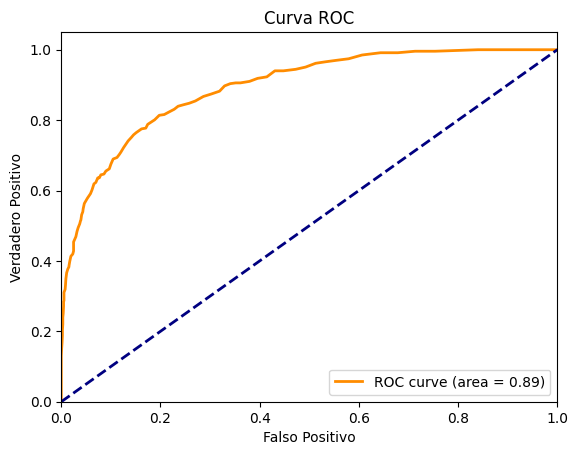

In [478]:
%time
#rf_model
rf_model = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

rf_grid_search.fit(feature_train_selected, target_train_balanced)

print("Mejor modelo Random Forest:")
print(rf_grid_search.best_estimator_)

print("Mejores hiperparámetros:")
print(rf_grid_search.best_params_)

print("Mejor puntuación AUC-ROC:")
print(rf_grid_search.best_score_)

best_rf = rf_grid_search.best_estimator_
best_rf.fit(feature_train_selected, target_train_balanced)

y_pred = best_rf.predict(feature_test_selected)
y_pred_proba = best_rf.predict_proba(feature_test_selected)[:, 1]

print("Reporte de Clasificación:")
print(classification_report(test_target, y_pred))

print("Puntuación AUC-ROC:")
print(roc_auc_score(test_target, y_pred_proba))

fpr, tpr, _ = roc_curve(test_target, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Por último, tenemos el modelo de Bosque Aleatorio el cual ha presentado una puntuación de 0.89, cumpliendo también con lo exigido por Interconnect, aunque, eso sí, hay que tener en cuenta que es más propenso a confundir las clases si lo comparamos con GradientBoost. Además, se ha de tener en cuenta que este valor es posible mejorarlo si se hace un respectivo ajuste a los hiperparámetros correspondientes.

Como se comento al inicio, es bastante bueno considerar usar el modelo de bosque aleatorio para la predicción en el abandono por parte del cliente para con Interconnect, este tiene una implementación y nivel de ajuste menos complejo de lo que requieren algunos otros modelos. 

Sea cual fuere la decisión de Interconnect, se espera que en el presente proyecto se haya facilitado en una visión, lo más general posible, sobre el comportamiento futuro de los clientes teniendo en cuenta el conjunto de datos dados por estos.

En el informe final se harán algunas recomendaciones más, se tratará de condensar el presente proyecto y todo lo abordado para la predicción y calculo en la tasa de abandono futura como conclusión del mismo.

### Modelos excluidos

Como se comento, igual se mostrará y se pondran a prueba otros 3 modelos más que, pesé a no haber calificado como nuestro 3 modelos principales, trataremos igual de hecharle un vistazo para ver el comportamiento de estos.

CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 9.06 μs
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/s

Mejor modelo XGBoost:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
Mejores hiperparámetros:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Mejor puntuación AUC-ROC:
0.9812098735278134


/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:13:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1291
           1       0.95      0.80      0.87       467

    accuracy                           0.94      1758
   macro avg       0.94      0.89      0.91      1758
weighted avg       0.94      0.94      0.93      1758

Puntuación AUC-ROC:
0.9667721020340124


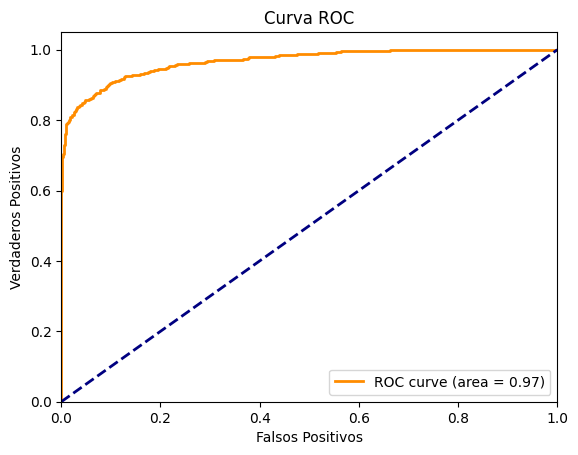

In [474]:
%time
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

xgb_grid_search.fit(feature_train_selected, target_train_balanced)

print("Mejor modelo XGBoost:")
print(xgb_grid_search.best_estimator_)

print("Mejores hiperparámetros:")
print(xgb_grid_search.best_params_)

print("Mejor puntuación AUC-ROC:")
print(xgb_grid_search.best_score_)

best_xgb = xgb_grid_search.best_estimator_
best_xgb.fit(feature_train_selected, target_train_balanced)

y_pred = best_xgb.predict(feature_test_selected)
y_pred_proba = best_xgb.predict_proba(feature_test_selected)[:, 1]

print("Reporte de Clasificación:")
print(classification_report(test_target, y_pred))

print("Puntuación AUC-ROC:")
print(roc_auc_score(test_target, y_pred_proba))

fpr, tpr, _ = roc_curve(test_target, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

CPU times: user 4 μs, sys: 2 μs, total: 6 μs
Wall time: 8.34 μs
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejor modelo CatBoost:
Mejores hiperparámetros:
{'depth': 7, 'iterations': 200, 'learning_rate': 0.1, 'subsample': 0.8}
Mejor puntuación AUC-ROC:
0.9806866397908693
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1291
           1       0.95      0.80      0.87       467

    accuracy                           0.93      1758
   macro avg       0.94      0.89      0.91      1758
weighted avg       0.94      0.93      0.93      1758

Puntuación AUC-ROC:
0.9633453143737652


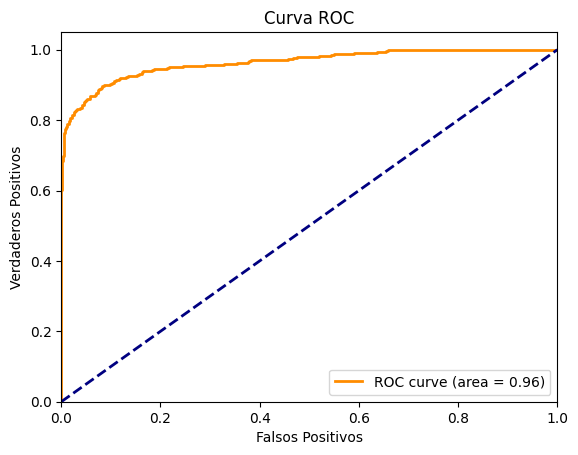

In [475]:
%time
cb_model = CatBoostClassifier(silent=True)

catboost_param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

catboost_grid_search = GridSearchCV(estimator=cb_model, param_grid=catboost_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

catboost_grid_search.fit(feature_train_selected, target_train_balanced)

print("Mejor modelo CatBoost:")
print(catboost_grid_search.best_estimator_)

print("Mejores hiperparámetros:")
print(catboost_grid_search.best_params_)

print("Mejor puntuación AUC-ROC:")
print(catboost_grid_search.best_score_)

best_catboost = catboost_grid_search.best_estimator_
best_catboost.fit(feature_train_selected, target_train_balanced)

y_pred = best_catboost.predict(feature_test_selected)
y_pred_proba = best_catboost.predict_proba(feature_test_selected)[:, 1]

print("Reporte de Clasificación:")
print(classification_report(test_target, y_pred))

print("Puntuación AUC-ROC:")
print(roc_auc_score(test_target, y_pred_proba))

fpr, tpr, _ = roc_curve(test_target, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Una pequeña comparación:
- Rendimiento:
    - XGBOOST: 0.9667
    - CatBoost: 0.9633
    - GradientBoosting: 0.9744
    - RandomForest: 0.8920

- Eficiencia Computacional:
    - CatBoost: 24 candidatos, 120 fits, conocido por ser muy eficiente, especialmente con datos categóricos, y puede ser más rápido que XGBoost.
    - XGBoost: 48 candidatos, 240 fits, es un modelo muy potente, pero puede ser más lento que CatBoost debido a cómo maneja el ajuste de hiperparámetros y cálculos de gradientes.
    - Random Forest: 144 candidatos, 720 fits, aunque es más sencillo de entrenar, el número de candidatos y fits fue significativamente mayor, implicando costo computacional más alto.
    - Gradient Boosting: 24 candidatos, 120 fits. En costo computacional, parecido a CatBoost pero con resultados de AUC-ROC superiores.

- Facilidad de Interpetación:
    - Random Forest es el más fácil de interpretar, pues es un conjunto de árboles de decisión, y su output es más comprensibles.
    - Gradient Boosting, aunque similar a RF, puede ser un poco más complejo debido a la secuencialidad del boosting.
    - XGBoost y CatBoost son más difíciles de interpretar. Ambos utilizan técnicas avanzadas de boosting. Eso sí, CatBoost ofrece algunas ventajas en términos de interpretabilidad nativa para variables categóricas.

### Modelo excluido: Red Neuronal con Keras

La red que se contruye a continuación consta de una capa de entrada con tantas neuronas como el número de características en feature_train_selected, contiene dos capas ocultas:
- Primera capa con 15 neuronas y función de activación tanh.
- Segunda capa con 5 neuronas, también usando tanh.
- Capa de salida: una sola neurona con activación sigmoid esto producirá una probabilidad que clasifica entre dos clases.

Se generaran probabilidades de clase con predict y se binarizaran las predicciones con un umbral de 0.5.

In [477]:
%time
neural_model = tf.keras.models.Sequential()
neural_model.add(tf.keras.layers.Dense(units=15, input_dim=feature_train_selected.shape[1], activation='tanh'))
neural_model.add(tf.keras.layers.Dense(units=5, activation='tanh'))
neural_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#compilo
neural_model.compile(loss='binary_crossentropy', #función de pérdida. Problemas de clasificación binaria
             optimizer=tf.keras.optimizers.Adam(),#optimización estocástica del gradiente
             metrics=[tf.keras.metrics.AUC(name='auc')])



early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = neural_model.fit(feature_train_selected, 
                   target_train_balanced, 
                   epochs=100, 
                   batch_size=32, 
                   validation_data=(feature_valid_selected, valid_target),
                   callbacks=[early_stopping])#detiene el entrenamiento ayudando a evitar un número innecesario de epocas


loss, auc_score = neural_model.evaluate(feature_test_selected, test_target, verbose=0)
print(f"Puntuación AUC-ROC en conjunto de prueba: {auc_score}")

# Realizar predicciones
y_pred_proba = neural_model.predict(feature_test_selected).ravel()  # Probabilidades para AUC-ROC
y_pred = (y_pred_proba > 0.5).astype(int)  # Predicciones binarizadas

print("Reporte de Clasificación:")
print(classification_report(test_target, y_pred))

print("Puntuación AUC-ROC:")
print(roc_auc_score(test_target, y_pred_proba))

CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 9.54 μs
Epoch 1/100


/home/USER/anaconda3/envs/ml_ubuntu/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.6249 - loss: 0.6576 - val_auc: 0.0000e+00 - val_loss: 0.4044
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8486 - loss: 0.4842 - val_auc: 0.0000e+00 - val_loss: 0.2335
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8546 - loss: 0.4726 - val_auc: 0.0000e+00 - val_loss: 0.1645
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8611 - loss: 0.4639 - val_auc: 0.0000e+00 - val_loss: 0.1563
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8570 - loss: 0.4672 - val_auc: 0.0000e+00 - val_loss: 0.1379
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8631 - loss: 0.4594 - val_auc: 0.0000e+00 - val_loss: 0.1169
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8594 - loss: 0.4624 - val_auc: 0.0000e+00 - val_loss: 0.1065
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8655 - loss: 0.4540 - val_auc: 0.0000e+00 - val_loss: 0.1051
Epoch 9/100
242/242 ━━━━━━━━

Obtenemos las epocas suficientes y observamos que para las clases existe:
    - Clase 0: Precisión de 0.91, recall de 0.81
    - Clase 1: Precisión de 0.60, recall de 0.77

AUC-ROC: 0.871, lo cual indica una buena capacidad para discriminar entre las dos clases. El modelo detecta bien los casos positivos. Precisión para la clase 1 es relativamente baja (0.60), lo que podría indicar un desbalance en los datos o, lo más seguro, un desajuste en los hiperparámetros.

# CONCLUSIÓN

Una vez obtenido y analizado, tantos los datos iniciales como los resultados arrojados por los distintos modelos de aprendizaje, es hora de que el lider del equipo apruebe alguno de estos, donde se espera además, él mismo tome en consideración los argumentos defendidos por el presente investigador sobre las variables manejadas, el proceso de encodificado, el planteamiento de la división de los datos en los respectivos conjuntos, hasta, por supuesto, los modelos analizados y propuesto para alcanzar las métricas deseadas por Interconnect.

Es bueno remarcar la parte de la sugerencia sobre RandomForestClassifier. Me tomo la libertad de tal sugerencia, debido a que no se explicita el modelo a usar, por lo que, basandome en los análisis anteriores, de los 3 modelos seleccionados, se recomienda, primero que nada, emplear Bosques Aleatorios para realizar las respectivas predicciones sobre el abandono, luego, sería interesante considerar a GradienteBoost, pesé a la complejidad del mismo, este ha demostrado ser de los mejores, incluso más que RandomForest, pero debido a la compejidad del mismo, lo recomendaría como segunda opción. Todo esto, por supuesto dependerá al final de los recursos, el tiempo y las métricas que se quieran alcanzar.

Por último, como tercerá recomendación, podría ser catboost, un modelo que demostró también ser bastante representativo en el entrenamiento y las predicciones; ya se vio que MLPClassifier es sensible a los ajustes en los hiperparámetros y, pesé a ser de los mejores modelos, para esta tarea de clasificación no recomendaría emplearla.
Es correcto decir que, es posible ahondar un poco más en los datos para crear nuevas carásteristicas y reentrenar modelos para obervar si estos son más exactos o más óptimos respecto a las nuevas características que puedan agregarse a los datos mediante la ingeniería de estas.


Se tuvo que omitir el paso de los valores SHAP debido a fallas en el código al momento de ejecutarse .shap_summary , por lo que se procedio a analizar el comportamientos de las selecciones hechas por boruta a través de validación cruzada empleando StratifiedKFold.
A parte de la anterior dificultad, el proceso de encodificado fue un poco complicado al momento de elegir entre el drop='first' y el agregado en el nombre de las columnas en los datos resultantes a la encodificación y escalado. Se pudo abordar accediendo a la información de la respectiva librería, al igual que en muchos pasos realizados a través del presente trabajo.

Es bastante fácil preveer cuáles son los pasos claves para la solución del proyecto y el cumplimiento de lo exigido por Interconnect: el análisis exploratorio inicial de datos para comprender, en la medida de lo posible, la distribución, estadística e información que poseen los mismos. El manejo de los valores ausentes fue clave, teniendo en cuenta que se debían tratar de maneras específicas para que el modelo de aprendizaje discriminase mejor. Además, se optimizo la distribusión de clases con SMOTE para balancearlas, permitiendo generar muestras sintéticas de la clase minoritaria sin perder información valiosa, así aseguramos que el modelo no esté sesgado hacia la clase mayoritaria y poder trabajar el problema de clasificación desbalanceado que se nos presenta. La ingeniería de características y la selección de las mismas hechas por Boruta fueron decisivas, pues nos permitiío obtener las características más relevantes de los datos respecto al target (abandono); se combinó, como se vio, con un algoritmo basado en Random Forest, añadiendo un nivel extra de estabilidad, ya que trabaja bien con conjuntos de datos complejos; probablemente, quienes mejoraron el rendimiento del modelo al crearse y seleccionarse las características más relevantes para realizar las predicciones en el conjunto de prueba antes de estudiar, con hiperparametros ajustados y seleccionados por GridSearch, las predicciones en el respectivo conjunto de entrenamiento dado los lineamientos de interconnect. Por último, también es imporante destacar el trabajo hecho con el Pipeline y la validación cruzada, pues esto permitió confirmar que las características seleccionadas son estables dado distintas particiones de datos sin verse interrumpido o repetitivo en la evaluación de otros modelos gracias al pipeline creado; esto permitió tener un flujo más eficiencia al momento del trabajo, obteniendo entonces una garantía en la replicabilidad de cada paso en cada uno de modelos, una ventaja para trabajar de manera consistente y coherente en la aplicación de las trasnformaciones respectivas y necesarias para cada uno de los conjuntos.

El modelo final seleccionado:

    - GradientBoostingClassifier con AUC-ROC = 0.97. Mejor modelo optimizado en max_depth=7, n_estimators=200, learning_rate=0.1 y subsample=1.0. En tal proceso de optimizacións, el mejor modelo alcanzó AUC-ROC=0.9815. Su Accuracy 0.94, acertando el 94% de las predicciones.

Modelo a considerar:

    - RandomForestClassifier con AUC-ROC=0.89, superando lo solicitado. Eso sí, es propenso a confundir las clases, pero, la facilidad de manipulación del modelo permite jugar con los hiperparámetros del mismo, esto se puede observar ya que la mejor puntuación obtenida por parte del bosque aleatorio fue de 0.96, por lo que sería de interés tomarlo en consideración, pese al alto coste computacional.

Como recomendaciones finales, observando la pequeña comparación realizado en los modelos excluidos, CatBoost sería una opción muy competitiva y deseable, pues posee un alto AUC-ROC, sin mencionar que es más rápido de entrenar. Es verdad que XGBoost posee un rendimiento ligeramente superior pero, en términos de computabilidad, puede ser más costos pesé a ofecer más flexibilidad en el ajuste fino del modelo.
Ahora, puede que RandomForest halla cumplido con lo deseado por poco, pero el coste computacional que requiere para nuestra solución es de las más altas, caso contrario que pasa con GradientBoosting aunque este último es un poco menos interpretable.

En fin, en términos de eficiencia computacional, CatBoost tiende a ser más rápido que XGBoost, especialmente en conjuntos de datos categóricos o grandes debido a su capacidad para manejar categorías sin necesidad de codificación explícita, pero como aquí se ha realizado, se ha obtenido un resultado bastante deseable y competitivo como para tomarlo en cuenta. Sin embargo, XGBoost ofrece una alta flexibilidad y personalización en ajustes de hiperparámetros, por lo que la elección en la implementación de tal o cual modelo dependerá de todas estás variables que se han mencionado.